# HDDM Tutorial: Example script using Ostwald's data

This is the script for illustrating a principled workflow of hierarchical bayesian drift diffusion modelling. We used data from Ostwald (Geogie et al, 2018; Ostwald et al., 2012) as an example.

## Information about the experiment (recap)
This dataset was based on a 2 by 2 by 2 within subject design, with factors stimulus coherence (low, high) and spatial prioritization (yes, no). 

Data are from 17 participants (8 female, mean age 25.9 yrs, rang 20 ~ 33, 2 left-handed) recruited from University of Birmingham. 

Original stimulus set include 18 pictures of cars and 18 pictures of faces. 

Procedure:

EEG experiment outside MRI scanner (72 trials/condition) --> EEG inside scanner (90 trials/condition)

We preprocessed the behavioral data so that all data are now in the same `csv` file.  

 * stim ---- 1 means face; 0 means car
 * response ---- 1 means paratcipants they pressed the face button; 0 means they pressed the car button
 
 
For simplicity, we will only use the data outside scanner.

Note: We also have a second `csv` file (`df_Ostwald_acc_code.csv`) for accuracy coding, where the `response` is the accuracy instead the key participants pressed.

**Reference of the data**

Georgie, Yasmin K., Camillo Porcaro, Stephen D. Mayhew, Andrew P. Bagshaw, and Dirk Ostwald. “A Perceptual Decision Making EEG/FMRI Data Set.” BioRxiv, January 25, 2018, 253047. https://doi.org/10.1101/253047.

Ostwald, Dirk, Camillo Porcaro, Stephen D. Mayhew, and Andrew P. Bagshaw. “EEG-FMRI Based Information Theoretic Characterization of the Human Perceptual Decision System.” PLOS ONE 7, no. 4 (April 2, 2012): e33896. https://doi.org/10.1371/journal.pone.0033896.

## Test installed packages

Please make sure that you've installed docker and pulled the [`hcp4715/hddm:arviz`](https://hub.docker.com/r/hcp4715/hddm) image.

The code below is testing whether you are using the corrent docker image. Run the code block below, you should see output like this:

`Notebook is running: /opt/conda/bin/python` 

`The current Python version is 3.7.10`

`The current HDDM version is 0.8.0`

`The current Kabuki version is 0.6.3`

`The current PyMC version is 2.3.8`

`The current IPython version is 7.15.0`

`The current Numpy version is 1.19.1`

`The current Pandas version is 1.0.5`

`The current seaborn version is 0.11.0`


In [1]:
# check the current python version, make sure this is the one that with HDDM correctly installed
import sys
sys.executable

# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current Python version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython, kabuki, pymc
import numpy as np
import pandas as pd
import seaborn as sns
import ipyparallel
import cufflinks
import ptitprince
# import p_tqdm
import pymc3
import bambi

print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current IPython version is', IPython.__version__) 
print('The current ipyparallel version is', ipyparallel.__version__) 
print('The current Numpy version is', np.__version__) 
print('The current Pandas version is', pd.__version__)
print('The current seaborn version is', sns.__version__)
print('The current Kabuki version is', kabuki.__version__) # 0.6.3
print('The current PyMC version is', pymc.__version__) # 2.3.8

print('The current cufflinks version is', cufflinks.__version__) # 0.17.3
#print('The current ptitprince version is', ptitprince.__version__) # 

#print('The current p_tqdm version is', p_tqdm.__version__) # 
print('The current pymc3 version is', pymc3.__version__) # 3.11.2
print('The current bambi version is', bambi.__version__) # 0.5.0

Notebook is running: /opt/conda/bin/python
The current Python version is 3.7.6


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


The current HDDM version is 0.8.0
The current IPython version is 7.15.0
The current ipyparallel version is 6.3.0
The current Numpy version is 1.19.4
The current Pandas version is 1.0.5
The current seaborn version is 0.11.1
The current Kabuki version is 0.6.3
The current PyMC version is 2.3.8
The current cufflinks version is 0.17.3
The current pymc3 version is 3.11.2
The current bambi version is 0.5.0


In [2]:
# NOTE: I hacked the `post_pred_gen`, 
# more detals: https://groups.google.com/g/hddm-users/c/Is6AM7eN0fo
from post_pred_gen_redifined import _parents_to_random_posterior_sample
from post_pred_gen_redifined import _post_pred_generate
from post_pred_gen_redifined import post_pred_gen

In [3]:
from p_tqdm_new import p_map

## Import packages need for analyses

In [4]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import kabuki 
import datetime

# import the toolbox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns

# set the color of plots
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

In [5]:
# load data, note that I have preprocessed Ostwald's data so that it fit HDDM's format
df = hddm.load_csv('df_PDM.csv')
data = df[df['status'] == 'outside']
data.head() 

# preprocessing the data to get a accuracy-coding version
# df_m1 = df.drop(['response'], axis=1)
# df_m1 = df_m1.rename(columns={'accuracy':'response'})  # change the column name to 
# df_m1.head()
# df_m1.to_csv('df_Ostwald_acc_code.csv', index=False)

subj_idx   status  runid  condition      cue coherence  image_index  stim  \
0         1  outside      1          1    valid      high           19     1   
1         1  outside      1          2  invalid      high           12     0   
2         1  outside      1          2  invalid      high           20     1   
3         1  outside      1          1    valid      high            5     0   
4         1  outside      1          1    valid      high           13     0   

   response        rt  accuracy  stimulus_side  
0         1  0.529206         1              0  
1         0  0.519501         1              0  
2         1  0.611204         1              0  
3         0  0.465089         1              0  
4         0  0.367166         1              1

## Visualization of the data

### The way HDDM visualizes data


Below is the way to visualize the raw data as demonstrated in HDDM's tutorial.

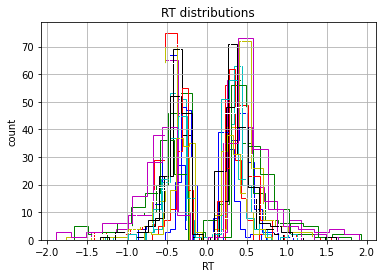

In [6]:
data_flip = hddm.utils.flip_errors(data)

# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data_flip.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_df_behav_ostwald.pdf')

### Multiple (better) ways to visualize the data in Python

#### First, visualize the summary data, as presented in the [preprint](https://www.biorxiv.org/content/10.1101/253047v1)

Here, we demonstrated two ways to visualize the data: bar plots (with error bar) and raincloud plots.

Before we jump into the plots, we can also check the number of trials for each condition of each participant.

In [7]:
# df["cond"] = df["cue"] + "_" + df["coherence"] # combine two string columns to one

# # check the trials for accurate and wrong responses
# df.groupby(['status', 'subj_idx', 'cue', 'coherence', 'accuracy']).size()

# df = df[df['status'] == 'outside']
data.groupby(['subj_idx', 'cue', 'coherence', 'accuracy']).size()

subj_idx  cue      coherence  accuracy
1         invalid  high       0            2
                              1           70
                   low        0            3
                              1           69
          valid    high       0            2
                                          ..
17        invalid  low        1           56
          valid    high       0            1
                              1           71
                   low        0           12
                              1           60
Length: 121, dtype: int64

When visualize the data, we tried to replicate the Figure 2a in Georgie et al (2018). 

First, get the median of each condition for each participant, then, plot the mean and SD (instead of SE in the manuscript).

The plot looks like a bit different to the Fig 2a in the preprint.

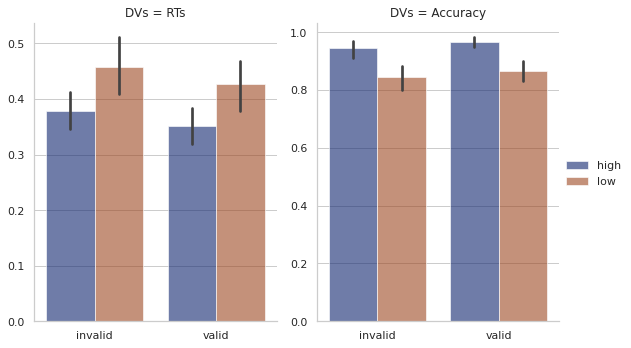

In [8]:
# get the median of accurate RTs
data_rt_sum = data[data['accuracy'] ==1].groupby(['subj_idx','cue', 'coherence'])['rt'].median().reset_index()

# get the mean accuracy (this approach is not optimal)
data_acc_sum = data.groupby(['subj_idx','cue', 'coherence'])['accuracy'].mean().reset_index()

# # categorize the cond and order the data
# from pandas.api.types import CategoricalDtype

# cat_type = CategoricalDtype(categories=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
#                            ordered=True)
# df_rt_sum['cond'] = df_rt_sum['cond'].astype(cat_type)
# df_acc_sum['cond'] = df_acc_sum['cond'].astype(cat_type)
data_rt_sum['DVs'] = 'RTs'
data_rt_sum.rename(columns={'rt':'value'}, inplace=True)
data_acc_sum['DVs'] = 'Accuracy'
data_acc_sum.rename(columns={'accuracy':'value'}, inplace=True)

data_sum = pd.concat([data_rt_sum, data_acc_sum]).reset_index(drop=True)  # concat two dataframes
# df_sum['cond'] = df_sum['cond'].astype(cat_type)

### MUST use map_dataframe()
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(data=data_sum, col="DVs", height=5, aspect=.8, sharex=True, sharey=False)
g.map_dataframe(sns.barplot, x='cue', y="value", hue = 'coherence', 
                #order=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                #ci = 'sd', # not used, boostrap confidence interval will be used?
                palette="dark", alpha=.6,)
g.add_legend()

We can also used the [`raincloud` plot](https://wellcomeopenresearch.org/articles/4-63/v2), which shows both the individual data and group data.

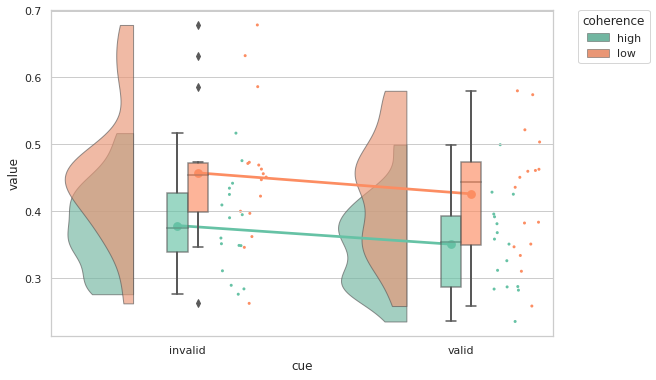

In [9]:
# plot raincloud of RT
import ptitprince as pt

dx = "cue"; dy = "value"; dhue = "coherence"; ort = "v"; pal = "Set2"; sigma = .4

f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=data_rt_sum, palette=pal, 
                  bw=sigma, width_viol=.5,
                  ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

We also need to visual inspect individual data. So we will plot individual data using interactive plots `plotly`.

In [10]:
df_p = data.set_index(['subj_idx'])
df_p.describe()

runid    condition  image_index         stim     response  \
count  4567.000000  4567.000000  4567.000000  4567.000000  4567.000000   
mean      1.498796     2.500328    36.496387     0.499891     0.515656   
std       0.500053     1.118646    20.798017     0.500055     0.499810   
min       1.000000     1.000000     1.000000     0.000000     0.000000   
25%       1.000000     1.000000    18.500000     0.000000     0.000000   
50%       1.000000     3.000000    37.000000     0.000000     1.000000   
75%       2.000000     4.000000    55.000000     1.000000     1.000000   
max       2.000000     4.000000    72.000000     1.000000     1.000000   

                rt    accuracy  stimulus_side  
count  4567.000000  4567.00000    4567.000000  
mean      0.444401     0.90716       0.500109  
std       0.218037     0.29024       0.500055  
min       0.000117     0.00000       0.000000  
25%       0.314099     1.00000       0.000000  
50%       0.393480     1.00000       1.000000  
75%       0.510559     1.00000       1.000000  
max       1.924480     1.00000       1.000000

In [11]:
# # import packages and function for interactive plotting
# import chart_studio.plotly as py
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot,iplot_mpl
# from plotly.graph_objs import *
# import cufflinks as cf
# init_notebook_mode(connected=True)

# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

In [12]:
# @interact(index_name=df_p.index.unique())  # can we use subject's number as the index_name?
# def iplot_scale(index_name):
#     df_tmp = df_p[df_p.index==index_name]['rt']
#     iplot(df_tmp.iplot(asFigure=True,kind='histogram', bins = 50,subplots=True, shape=(1, 1), filename='histogram-subplots'))

#### Data pre-processing

As we can see from the above, some participant have extremely long Rts ( ~ 8 seconds). To avoid the problem in further analysis, we can remove the outliers. Note that there are multiple methods to remove outliers, here we choose Rousseeuw & Croux's measure of spread, $S_{n}$, as the critirion for excluding outliers in RT, as suggested by [Jones (2019, APP)](https://link.springer.com/article/10.3758/s13414-019-01726-3). 

We will define a function of $S_{n}$ based on [Jones (2019, APP)](https://link.springer.com/article/10.3758/s13414-019-01726-3), instead of use `robustbase` package directly. One importance difference between the two algorithm is whether or not use a constant multiplier.

* Note about $S_{n}$ method: this was implemented in python package [`robustbase`](https://github.com/deepak7376/robustbase), $S_{n}$

In [13]:
def Sn(x,finite_corr=True):
    """
    Sn scale estimator , Gaussian efficiency 58%
    Note, there is no constant as in the robustbase pacakge
    """
    import statistics
    import numpy as np
    import pandas as pd
    x = x.tolist() # convert to list
    n = len(x)

    if n==0:
        raise Exception("x sholud be non-empty !!!")
    if n==1:
        return 0
    
    med=[]
    for idx, val in enumerate(x):
        # remove the current value from the array
        if isinstance(x, pd.Series): # check if the input is a pandas series
            x_rest = x.drop(idx)
        else:
            x_rest = np.array(x[:idx] + x[idx+1 :])
        
        x_diff = x_rest - val  # calculate the differences between current value and the rest
        x_med = statistics.median(abs(x_diff)) # get the median of the absolute diffrences
        med.append(x_med)
    
    # choose the finite correction based on n 
    if n <= 9:
        bias_corr = [0, 0.743, 1.851, 0.954, 1.351, 0.993, 1.198, 1.005, 1.131][n-1]
    elif n > 9 & n % 2 == 1:  # n is odd
        bias_corr = n/(n-.9)
    else:             # n is even
        bias_corr = 1
    
    # calculate the Sn value
    Sn_value = round(bias_corr * statistics.median(med), 6) if finite_corr==True else round(statistics.median(med), 6)     
    Sn_values = np.array([Sn_value] * n)
    med_dist = np.array(med)
    return Sn_values, med_dist 

In [14]:
# calculate outliers based on participant
Sn_vals = []
med_dists = []
for sub in data["subj_idx"].unique():
#     print(sub)
#     for cond in df["status"].unique():
    tmp_rt = data.loc[(data["subj_idx"] ==sub)]["rt"]
#         print(len(tmp_rt))
    if (len(tmp_rt) ==0):
        continue
    else:  
        Sn_, med_ = Sn(tmp_rt)
    Sn_vals.append(Sn_)
    med_dists.append(med_)
        
Sn_vals = np.concatenate(Sn_vals, axis=0)
med_dists = np.concatenate(med_dists, axis=0)

# select valid data
data_v = data
data_v['Sn_vals'] = Sn_vals
data_v['med_dists'] = med_dists
data_v['Outliers'] = np.where(data_v['med_dists'] >= data_v['Sn_vals']*3, True, False)
data_v = data_v.loc[data_v['Outliers'] == False]

print(data_v.shape)
print("ratio of invalid trial 2 : ", (len(data) - len(data_v))/len(data))


(4222, 15)
ratio of invalid trial 2 :  0.07554193124589446


In [15]:
data_v = data_v.loc[data_v['rt'] >= 0.2]

In [16]:
print(data_v.shape)
data_v.head()

(4041, 15)


subj_idx   status  runid  condition      cue coherence  image_index  stim  \
0         1  outside      1          1    valid      high           19     1   
1         1  outside      1          2  invalid      high           12     0   
2         1  outside      1          2  invalid      high           20     1   
3         1  outside      1          1    valid      high            5     0   
4         1  outside      1          1    valid      high           13     0   

   response        rt  accuracy  stimulus_side   Sn_vals  med_dists  Outliers  
0         1  0.529206         1              0  0.090001   0.110997     False  
1         0  0.519501         1              0  0.090001   0.105250     False  
2         1  0.611204         1              0  0.090001   0.178164     False  
3         0  0.465089         1              0  0.090001   0.082345     False  
4         0  0.367166         1              1  0.090001   0.080289     False

In [17]:
#df_p2.columns = df_p2.columns.get_level_values(0)
df_p2 = data_v
df_p2 = df_p2.set_index(['subj_idx'])
df_p2.describe()

runid    condition  image_index         stim     response  \
count  4041.000000  4041.000000  4041.000000  4041.000000  4041.000000   
mean      1.497154     2.483296    36.133630     0.496164     0.512002   
std       0.500054     1.115942    20.811101     0.500047     0.499918   
min       1.000000     1.000000     1.000000     0.000000     0.000000   
25%       1.000000     1.000000    18.000000     0.000000     0.000000   
50%       1.000000     2.000000    36.000000     0.000000     1.000000   
75%       2.000000     3.000000    54.000000     1.000000     1.000000   
max       2.000000     4.000000    72.000000     1.000000     1.000000   

                rt     accuracy  stimulus_side      Sn_vals    med_dists  
count  4041.000000  4041.000000    4041.000000  4041.000000  4041.000000  
mean      0.413053     0.918337       0.502103     0.106974     0.121192  
std       0.135366     0.273884       0.500057     0.034233     0.067099  
min       0.200154     0.000000       0.000000     0.065143     0.049805  
25%       0.317530     1.000000       0.000000     0.081289     0.076007  
50%       0.387793     1.000000       1.000000     0.095754     0.100907  
75%       0.480232     1.000000       1.000000     0.128608     0.144131  
max       1.072773     1.000000       1.000000     0.186919     0.557175

In [18]:
# # for jupyter lab users, please see this: 
# # https://stackoverflow.com/questions/54064245/plot-ly-offline-mode-in-jupyter-lab-not-displaying-plots
# @interact(index_name=df_p2.index.unique())  # can we use subject's number as the index_name?
# def iplot_scale(index_name):
#     df_tmp = df_p2[df_p2.index==index_name]['rt']
#     iplot(df_tmp.iplot(asFigure=True,kind='histogram', bins = 50,subplots=True, shape=(1, 1), filename='histogram-subplots'))

In [19]:
# data_v.to_csv('data_PDM_v.csv')

## Traditional analyses (optional in the future, can be removed)

In case we also want to use traditional Bayesian hierarchical model using `pymc3` and [`bambi`](https://github.com/bambinos/bambi), e.g., using signal detection theory to model accuracy and `shifted log normal` to model RTs. So I tested these tools inside this docker image, using `bambi`'s example.

In [20]:
import bambi as bmb
import arviz as az

# # check whether bambi works
# data = pd.DataFrame({
#     "y": np.random.normal(size=50),
#     "g": np.random.choice(["Yes", "No"], size=50),
#     "x1": np.random.normal(size=50),
#     "x2": np.random.normal(size=50)
# })

# # Test the bambi package
# model = bmb.Model(data)
# fitted = model.fit("y ~ x1 + x2")

# az.plot_trace(fitted)

In [21]:
# az.summary(fitted)

## HDDM analyses

Now, we will start to use HDDM to model the data. Note that we skipped *prior predictive check*, *parameter recovery*.

### Model building

Here we can choose between `HDDM`, `HDDMStimCoding`, and `HDDMRegressor`, for each model, we can also choose how many parameters are free to vary across condition. 

We assume that boundary separation `a` and initial bias `z` do not vary across conditions (attentional cue and difficulty). Therefore we focused on the rest two parameters `v` and `t`. We hypothesize that (1) drift rate is modualted by task difficulty but to a less extend attention prioritization (Ratcliff & Mckoon, 2008), and (2) nondecision time is influenced by attention (Price, et al, 2019, Bio Psychiat) and status (inside vs. outside scanner) but not task difficulty.

We will build three models to test these hyotheses:
* M1: $v \sim cue + coherence$
* M2: $t \sim cue + coherence$
* M3: $v \sim cue + coherence, t \sim cue + coherence$

Because the data itself is a within-subject design, it's recommended by tutorial to use `HDDMRegressor` function, and we assume that `HDDMRegressor` is the best model in this case (Here parameter recovery can be used for model selection before we applying models to data). Below, we define three models using three functions for later parallel processing:

In [22]:
chains = 4
samples = 200
burn = 20

# from p_tqdm import p_map
from functools import partial

In [23]:
def m_basic(id, df=None, samples=None, burn=None, save_name='hddm'): 
    """
    Model 1: using HDDM depends_on, i.e., treat a within-subject design as a between-subj
    design
    """
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, depends_on={'v': ['cue', 'coherence', ],
                                  'a': ['cue', 'coherence'],})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

def mr_v(id, df=None, samples=None, burn=None, save_name='reg_v'):
    import hddm

#     exp_name = 'PDM_v'
#     model_tag = 'm1_v_reg'
#     print('running models %i'%id, 'for ', exp_name, ' ', model_tag)
    
#     # USE the absolute directory in docker.
#     dbname = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id # define the database name, which uses pickle format
#     mname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    # define the name for the model
#     fname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '.csv'
#     df = hddm.load_csv(fname)
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    # note: if Treatment() argument is not specified, it will be automatically order by alphbetical
    v_reg = {'model': "v ~ 1 + C(cue) * C(coherence, Treatment('low'))", 'link_func': lambda x: x}
    
    m = hddm.HDDMRegressor(df, v_reg, include='z', p_outlier = .05)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle')

    m.save(mname)
    return m

def mr_t(id, df=None, samples=None, burn=None, save_name='reg_t'):
    import hddm

#     exp_name = 'PDM_v'
#     model_tag = 'm2_t_reg'
#     print('running models %i'%id, 'for ', exp_name, ' ', model_tag)
    
#     # USE the absolute directory in docker.
#     dbname = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id # define the database name, which uses pickle format
#     mname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    # define the name for the model
#     fname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '.csv'
#     df = hddm.load_csv(fname)
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    t_reg = {'model': "t ~ 1 + C(cue) * C(coherence, Treatment('low'))", 'link_func': lambda x: x}
    
    m = hddm.HDDMRegressor(df, t_reg, include='z', p_outlier = .05)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle')

    m.save(mname)
    return m

def mr_vt(id, df=None, samples=None, burn=None, save_name='reg_vt'):
    # print('running model%i'%id);
    import hddm
    # import random
    #import os
    
    #cur_dir = os.getcwd()

#     exp_name = 'PDM_v'
#     model_tag = 'm3_vt_reg'
#     print('running models %i'%id, 'for ', exp_name, ' ', model_tag)
    
#     # USE the absolute directory in docker.
#     dbname = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id # define the database name, which uses pickle format
#     mname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    # define the name for the model
#     fname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '.csv'
#     df = hddm.load_csv(fname)
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    v_reg = {'model': "v ~ 1 + C(cue) * C(coherence, Treatment('low'))", 'link_func': lambda x: x}
    t_reg = {'model': "t ~ 1 + C(cue) * C(coherence, Treatment('low'))", 'link_func': lambda x: x}
    reg_descr = [v_reg, t_reg]
    
    m = hddm.HDDMRegressor(df, reg_descr, include='z', p_outlier = .05)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

In [24]:
from functools import partial
from pathos.multiprocessing import ProcessPool
from tqdm.auto import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# pool = ProcessPool()

# start_time = time.time()  # the start time of the processing

# jobs = pool.imap(partial(m_basic, df=data_v, samples=samples,
#                          burn=burn),
#                  range(chains))
# for item in jobs:
#     item
# # jobs = v.map(run_model, range(4)) # 4 is the number of CPUs

# # while not jobs.ready():
# #     time.sleep(5); print(".", end=' ')

# # wait_watching_stdout(jobs)

# # test = jobs.get()
# test = list(jobs)

# print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

In [25]:
# step 1: run model, list
ms_basic = p_map(partial(m_basic, df=data_v, samples=samples,
                         burn=burn),
                 range(chains))

# the progress bar that shows percentage is from pymc/progressbar.py
# using p_map destoried the original bar

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars



 -----------------100%-----------------] 200 of 200 complete in 31.2 sec                 2%                  ] 5 of 200 complete in 0.6 sec[                  2%                  ] 5 of 200 complete in 0.6 sec[                  2%                  ] 5 of 200 complete in 0.6 sec[-                 4%                  ] 9 of 200 complete in 1.2 sec[-                 4%                  ] 9 of 200 complete in 1.2 sec[-                 4%                  ] 9 of 200 complete in 1.2 sec[-                 4%                  ] 9 of 200 complete in 1.2 sec[--                6%                  ] 13 of 200 complete in 1.8 sec[--                6%                  ] 13 of 200 complete in 1.8 sec[--                6%                  ] 13 of 200 complete in 1.8 sec[--                6%                  ] 13 of 200 complete in 1.8 sec[---               8%                  ] 17 of 200 complete in 2.4 sec[---               8%                  ] 17 of 200 complete in 2.4 sec[---               8%      

In [26]:
test1 = m_basic(0, df=data_v, samples=samples, burn=burn, save_name='hddm')

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars



 [-----------------100%-----------------] 201 of 200 complete in 35.1 sec

In [28]:
pool = ProcessPool()
test2 = pool.map(partial(m_basic, df=data_v, samples=samples,
                         burn=burn),
                 range(chains))

 -                 4%                  ] 9 of 200 complete in 1.2 secc[                  2%                  ] 5 of 200 complete in 0.6 sec[                  2%                  ] 5 of 200 complete in 0.6 sec[                  2%                  ] 5 of 200 complete in 0.6 sec[-                 4%                  ] 9 of 200 complete in 1.2 sec [-                 4%                  ] 9 of 200 complete in 1.2 sec[-                 4%                  ] 9 of 200 complete in 1.2 sec[--                6%                  ] 13 of 200 complete in 1.8 sec[--                6%                  ] 13 of 200 complete in 1.8 sec[--                6%                  ] 13 of 200 complete in 1.8 sec[--                6%                  ] 13 of 200 complete in 1.8 sec[---               8%                  ] 17 of 200 complete in 2.4 sec[---               8%                  ] 17 of 200 complete in 2.4 sec[---               8%                  ] 17 of 200 complete in 2.5 sec[---               8%    

In [25]:
ms_reg_v = p_map(partial(mr_v, df=data_v, samples=samples,
                         burn=burn),
                 range(chains))

Adding these covariates:
['v_Intercept', 'v_C(cue)[T.valid]', "v_C(coherence, Treatment('low'))[T.high]", "v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', 'v_C(cue)[T.valid]', "v_C(coherence, Treatment('low'))[T.high]", "v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', 'v_C(cue)[T.valid]', "v_C(coherence, Treatment('low'))[T.high]", "v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
Adding these covariates:
['v_Intercept', 'v_C(cue)[T.valid]', "v_C(coherence, Treatment('low'))[T.high]", "v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]


/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars



 [                  0%                  ] 2 of 500 complete in 0.7 sec[                  0%                  ] 2 of 500 complete in 1.1 sec[                  0%                  ] 2 of 500 complete in 1.1 sec[                  0%                  ] 2 of 500 complete in 1.2 sec[                  0%                  ] 3 of 500 complete in 1.5 sec[                  0%                  ] 3 of 500 complete in 1.8 sec[                  0%                  ] 3 of 500 complete in 2.2 sec[                  0%                  ] 3 of 500 complete in 2.2 sec[                  0%                  ] 4 of 500 complete in 2.1 sec[                  0%                  ] 4 of 500 complete in 2.5 sec[                  0%                  ] 4 of 500 complete in 2.9 sec[                  1%                  ] 5 of 500 complete in 2.7 sec[                  0%                  ] 4 of 500 complete in 3.0 sec[                  1%                  ] 5 of 500 complete in 3.1 sec[                  1%            

Process ForkPoolWorker-23:
Process ForkPoolWorker-24:
Process ForkPoolWorker-25:
Process ForkPoolWorker-30:
Process ForkPoolWorker-22:
Process ForkPoolWorker-29:
Process ForkPoolWorker-21:


Halting at iteration 

Process ForkPoolWorker-32:


Process ForkPoolWorker-31:


 81

Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


 of 

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()


80

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()


  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()


  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


500

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


 of 

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()


  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()


  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 355, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line

500

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/connection.py", line 219, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchroniz

KeyboardInterrupt
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/connection.py", line 410, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


Halting at iteration 

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/connection.py", line 382, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


Halting at iteration   8179   of  of   500500

Could not generate output statistics forCould not generate output statistics forCould not generate output statistics for Could not generate output statistics for  a_subj.4a_subj.14 a_subj.3

z_trans
Could not generate output statistics forCould not generate output statistics for
Could not generate output statistics for  Could not generate output statistics for z_subj_trans.8v_Intercept_subj.11 z_subj_trans.7

a_subj.17
Could not generate output statistics forCould not generate output statistics for


Process ForkPoolWorker-27:


Could not generate output statistics for  Could not generate output statistics for a_subj.15v_Intercept_subj.8 v_Intercept_subj.11

t_std


Traceback (most recent call last):
Process ForkPoolWorker-28:


Could not generate output statistics forCould not generate output statistics for
Could not generate output statistics for

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()


  Could not generate output statistics for 

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


v_Intercept_subj.7a_subj.9a_subj.13 

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()


Traceback (most recent call last):


  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:


Could not generate output statistics fora_subj.12Could not generate output statistics for

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()


Could not generate output statistics for

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()


  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt


v_C(coherence, Treatment('low'))[T.high]v_Intercept_subj.4Could not generate output statistics fora_subj.10

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()


  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:


Could not generate output statistics fora_subj.10Could not generate output statistics for

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()


Could not generate output statistics for 
 

KeyboardInterrupt


a_subj.7 Could not generate output statistics fora_std
 
z_subj_trans.11Could not generate output statistics fort
Could not generate output statistics forCould not generate output statistics for 
 a_subj.10 Could not generate output statistics forv_Intercept_subj.17
 
z_subj_trans.5Could not generate output statistics fora_subj.1
Could not generate output statistics for 
Could not generate output statistics fora_subj.12Could not generate output statistics for  
 v_Intercept_subj.10v_Intercept_subj.11Could not generate output statistics for
t_subj.15
 Could not generate output statistics for
Could not generate output statistics forz_trans  Could not generate output statistics for
a_subj.13a_subj.8 Could not generate output statistics for

t_subj.17 Could not generate output statistics for
Could not generate output statistics forv_Intercept_subj.9 Could not generate output statistics for 
a_subj.11 v_Intercept_subj.16Could not generate output statistics for
v_Intercept_subj.1
 
Could not

Process ForkPoolWorker-26:


Could not generate output statistics for  
 z_subj_trans.3a_subj.6Could not generate output statistics fora_subj.9

 

Traceback (most recent call last):


Could not generate output statistics for
Could not generate output statistics forv_Intercept_subj.1 Could not generate output statistics for

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()



 z_subj_trans.7 

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


Could not generate output statistics forv_Intercept_subj.15v_Intercept_std
 

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()




Could not generate output statistics fora_subj.5

  File "/opt/conda/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:


Could not generate output statistics for Could not generate output statistics for


  File "/opt/conda/lib/python3.7/site-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()


 z_subj_trans.15 Could not generate output statistics for

KeyboardInterrupt



a_subj.11a_subj.14 Could not generate output statistics for
a_subj.8
 
Could not generate output statistics forCould not generate output statistics forz_subj.10Could not generate output statistics for 
  Could not generate output statistics fora_subj.5t_subj.16a_subj.11 


v_Intercept_subj.10Could not generate output statistics forCould not generate output statistics forCould not generate output statistics for
   Could not generate output statistics fora_subj.12v_Intercept_subj.3v_Intercept_subj.7 


t_subj.16Could not generate output statistics forCould not generate output statistics for
 Could not generate output statistics for t_subj.17Could not generate output statistics for 
z zCould not generate output statistics for
v_Intercept_subj.16
 
Could not generate output statistics forCould not generate output statistics forz_subj_trans.6Could not generate output statistics for  
 z_subj_trans.4a_subj.17Could not generate output statistics forz_subj.11

 
Could not generate output stat

KeyboardInterrupt: 

In [25]:
ms_reg_t = p_map(partial(mr_t, df=data_v, samples=samples,
                         burn=burn),
                 range(chains))

Adding these covariates:
['t_Intercept', 't_C(cue)[T.valid]', "t_C(coherence, Treatment('low'))[T.high]", "t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
Adding these covariates:
['t_Intercept', 't_C(cue)[T.valid]', "t_C(coherence, Treatment('low'))[T.high]", "t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
Adding these covariates:
['t_Intercept', 't_C(cue)[T.valid]', "t_C(coherence, Treatment('low'))[T.high]", "t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
Adding these covariates:
['t_Intercept', 't_C(cue)[T.valid]', "t_C(coherence, Treatment('low'))[T.high]", "t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]


/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning:

invalid value encountered in double_scalars



 [                  0%                  ] 3 of 500 complete in 0.7 sec[                  0%                  ] 3 of 500 complete in 0.7 sec[                  0%                  ] 3 of 500 complete in 0.7 sec[                  0%                  ] 3 of 500 complete in 0.9 sec[                  0%                  ] 4 of 500 complete in 1.3 sec[                  0%                  ] 4 of 500 complete in 1.2 sec[                  1%                  ] 5 of 500 complete in 1.7 sec[                  1%                  ] 5 of 500 complete in 1.8 sec[                  1%                  ] 6 of 500 complete in 2.1 sec[                  1%                  ] 6 of 500 complete in 2.1 sec[                  1%                  ] 7 of 500 complete in 2.5 sec[                  1%                  ] 7 of 500 complete in 2.7 sec[                  1%                  ] 8 of 500 complete in 2.9 sec[                  1%                  ] 8 of 500 complete in 3.1 sec[                  1%            

In [28]:
ms_reg_vt = p_map(partial(mr_vt, df=data_v, samples=samples,
                         burn=burn),
                 range(chains))

In [29]:
ms_reg_t[0].get_traces()

a     a_std  a_subj.1  a_subj.3  a_subj.4  a_subj.5  a_subj.6  \
0    0.998134  0.221998  0.873846  0.945258  0.964221  0.821343  0.989305   
1    0.927179  0.263473  0.860082  0.924494  0.961989  0.838228  1.021912   
2    0.951155  0.240089  0.873568  0.988249  0.935137  0.858120  1.011429   
3    0.900106  0.202702  0.850016  0.987928  0.939157  0.847376  1.030700   
4    0.866189  0.195602  0.887015  0.946466  0.913549  0.849890  0.994821   
..        ...       ...       ...       ...       ...       ...       ...   
395  0.922778  0.188641  0.867675  1.041965  0.891787  0.865723  1.010212   
396  0.955448  0.160447  0.873121  1.052807  0.981248  0.883007  1.035983   
397  0.912358  0.172960  0.926884  1.056893  0.961528  0.849053  1.033090   
398  0.902184  0.158836  0.849877  1.020765  0.948404  0.847558  1.051893   
399  0.860309  0.136291  0.867200  1.019770  0.940506  0.776755  1.054722   

     a_subj.7  a_subj.8  a_subj.9  ...  t_Intercept_subj.11  \
0    0.956648  0.750137  0.717677  ...             0.295739   
1    0.982508  0.782285  0.719439  ...             0.296225   
2    0.979113  0.768614  0.720172  ...             0.295576   
3    0.941535  0.812000  0.704511  ...             0.300266   
4    0.940167  0.806718  0.737938  ...             0.300391   
..        ...       ...       ...  ...                  ...   
395  0.983704  0.790065  0.800196  ...             0.295247   
396  0.991728  0.801888  0.813761  ...             0.298591   
397  0.975288  0.784412  0.804187  ...             0.299615   
398  0.953533  0.875165  0.840026  ...             0.292676   
399  0.968105  0.872152  0.820811  ...             0.296613   

     t_Intercept_subj.12  t_Intercept_subj.13  t_Intercept_subj.14  \
0               0.207317             0.198062             0.247368   
1               0.208176             0.202376             0.235719   
2               0.209948             0.204915             0.237742   
3               0.212444             0.197290             0.239229   
4               0.210384             0.198124             0.246049   
..                   ...                  ...                  ...   
395             0.209506             0.197725             0.242830   
396             0.208569             0.194816             0.236829   
397             0.207847             0.196277             0.235071   
398             0.210154             0.195783             0.242054   
399             0.211436             0.196082             0.236576   

     t_Intercept_subj.15  t_Intercept_subj.16  t_Intercept_subj.17  \
0               0.187865             0.194627             0.224810   
1               0.193290             0.193459             0.228335   
2               0.194849             0.196309             0.228467   
3               0.195943             0.189646             0.239105   
4               0.194649             0.200022             0.227705   
..                   ...                  ...                  ...   
395             0.190704             0.194131             0.233222   
396             0.190752             0.191985             0.233321   
397             0.190472             0.191568             0.230037   
398             0.189417             0.190178             0.219555   
399             0.188709             0.192394             0.230567   

     t_C(cue)[T.valid]  t_C(coherence, Treatment('low'))[T.high]  \
0            -0.005285                                 -0.009297   
1            -0.005880                                 -0.010579   
2            -0.007477                                 -0.010300   
3            -0.007889                                 -0.012110   
4            -0.006922                                 -0.012197   
..                 ...                                       ...   
395          -0.004035                                 -0.009558   
396          -0.005669                                 -0.007997   
397          -0.004824              

In [32]:
ms_reg_t[2].get_traces()

a     a_std  a_subj.1  a_subj.3  a_subj.4  a_subj.5  a_subj.6  \
0    0.890336  0.115810  0.911492  0.994773  0.969369  0.850423  1.039171   
1    0.884354  0.192160  0.920375  1.002106  0.921805  0.855633  0.999050   
2    1.002321  0.259768  0.930866  0.933029  0.906880  0.854006  1.000441   
3    0.858569  0.204273  0.855016  0.951322  0.884141  0.824579  1.019143   
4    0.925752  0.149155  0.873690  0.960098  0.903816  0.793465  0.992676   
..        ...       ...       ...       ...       ...       ...       ...   
395  0.864877  0.132637  0.864952  0.942014  0.919684  0.798144  0.993983   
396  0.889547  0.166432  0.862933  0.956710  0.944764  0.850831  1.002626   
397  0.881984  0.160827  0.858143  0.947043  0.954298  0.812206  1.011416   
398  0.923763  0.154168  0.875398  1.009004  0.936565  0.810190  1.007410   
399  0.875044  0.114055  0.876987  1.037738  0.943266  0.826305  1.010983   

     a_subj.7  a_subj.8  a_subj.9  ...  t_Intercept_subj.11  \
0    1.005641  0.810675  0.750075  ...             0.301601   
1    1.024578  0.801427  0.713927  ...             0.304364   
2    0.970428  0.780584  0.693239  ...             0.304034   
3    0.956840  0.824811  0.694827  ...             0.302737   
4    0.976179  0.791230  0.708505  ...             0.298057   
..        ...       ...       ...  ...                  ...   
395  0.966599  0.805586  0.727130  ...             0.302426   
396  1.023158  0.844453  0.739717  ...             0.300620   
397  1.037156  0.754300  0.723528  ...             0.300229   
398  1.008194  0.774900  0.735590  ...             0.303926   
399  0.960718  0.832598  0.711629  ...             0.303358   

     t_Intercept_subj.12  t_Intercept_subj.13  t_Intercept_subj.14  \
0               0.211854             0.204364             0.245067   
1               0.211541             0.209309             0.240342   
2               0.201278             0.205696             0.242111   
3               0.208355             0.198908             0.241130   
4               0.209957             0.199552             0.240875   
..                   ...                  ...                  ...   
395             0.210770             0.199425             0.291919   
396             0.203775             0.195919             0.290367   
397             0.202218             0.199073             0.284615   
398             0.202526             0.198576             0.291799   
399             0.207430             0.195180             0.291113   

     t_Intercept_subj.15  t_Intercept_subj.16  t_Intercept_subj.17  \
0               0.195822             0.200740             0.224761   
1               0.193975             0.201801             0.226100   
2               0.192575             0.198707             0.223245   
3               0.191504             0.200975             0.228425   
4               0.189969             0.189820             0.226298   
..                   ...                  ...                  ...   
395             0.192512             0.192232             0.228350   
396             0.190158             0.192515             0.236403   
397             0.189391             0.196592             0.231697   
398             0.193972             0.196280             0.225923   
399             0.193486             0.196349             0.226514   

     t_C(cue)[T.valid]  t_C(coherence, Treatment('low'))[T.high]  \
0            -0.007433                                 -0.012206   
1            -0.008120                                 -0.011354   
2            -0.007018                                 -0.010506   
3            -0.007718                                 -0.010237   
4            -0.006813                                 -0.009664   
..                 ...                                       ...   
395          -0.003649                                 -0.009598   
396          -0.001682                                 -0.010626   
397          -0.001678              

In [ ]:
# we can put all the above in a function to run all the coverting
# note: this function is specified for  this model
def model_to_arviz(df, model_name='df_m', **kwargs):
    """
    from data to arviz data
    """
    import arviz as az
    import numpy as np
    import pandas as pd
    import xarray as xr
    
    import hddm
    import kabuki
    
    from p_tqdm import p_map
    from functools import partial
    
    chains = 4
    samples=1500
    burn = 500
    model_name= model_name
    
    # step 1: run model, list    
    ms = p_map(partial(run_m1, df=df, samples=samples, 
                       burn=burn, save_name=model_name),
               range(4))
    
    # step 2: get ppc, list
    ppc_list = p_map(partial(post_pred_gen, 
                             samples = samples - burn),
                     ms)
    
    # step 3: get point-wise likelihoods, list
    loglik_list = p_map(partial(calc_plld, observed=df), ms)
    
    # step 4: Xarray
    # 4.1 observed
    obs_data_tmp = df.copy()
    obs_data_tmp['trial'] = obs_data_tmp.groupby(['subj_idx', 'stim']).cumcount()
    obs_data_tmp.drop(['theta','dbs','conf'], axis=1, inplace=True)
    obs_data_tmp = obs_data_tmp.set_index(["subj_idx", "stim", 'trial'])
    xdata_observed = xr.Dataset.from_dataframe(obs_data_tmp)
    
    # 4.2 posterior
    df_traces = []
    for jj in range(len(ms)):
        m = ms[jj]
        trace_tmp = m.get_traces()
        trace_tmp['chain'] = jj
        trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
#         print('chain', jj, trace_tmp.shape)
        df_traces.append(trace_tmp)
    df_traces = pd.concat(df_traces)
    df_traces = df_traces.set_index(["chain", "draw"])
    xdata_posterior = xr.Dataset.from_dataframe(df_traces)
    
    # 4.3 posterior predictive
    df_ppc = []
    for kk in range(len(ppc_list)):
        ppc_tmp = ppc_list[kk]
        ppc_tmp.reset_index(inplace=True)
        ppc_tmp['chain'] = kk
        ppc_tmp.rename(columns={'sample':'draw',
                                'level_2':'trial'}, inplace=True)
#         print('\nchain', kk, ppc_tmp.shape)
        ppc_tmp[['stim', 'subj_idx']] = ppc_tmp['node'].str.split(pat='\.', expand=True)
        # extract the stim string between "(" and ")"
        ppc_tmp['stim'] = ppc_tmp['stim'].str.extract('.*\((.*)\).*')
        ppc_tmp.drop('node', axis=1, inplace=True)
        df_ppc.append(ppc_tmp)
        
    df_ppc = pd.concat(df_ppc)
    df_ppc = df_ppc.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
    xdata_post_pred = xr.Dataset.from_dataframe(df_ppc)
    
    # point-wise log lik
    for chain in range(len(loglik_list)):
        loglik_list[chain]['chain'] = chain   
    df_loglik = pd.concat(loglik_list)
    
    df_loglik = df_loglik.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
    xdata_loglik = xr.Dataset.from_dataframe(df_loglik)
    
    # convert to InferenceData
    print("start to convert to Inference data.\n")
    InfData = az.InferenceData(posterior=xdata_posterior, 
                               observed_data=xdata_observed,
                               posterior_predictive=xdata_post_pred,
                               log_likelihood = xdata_loglik)

    return ms, df_traces, df_ppc, InfData

In [23]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

Using `ipyparallel` for parallel processing, please make sure that you have started multiple engines at the `IPython Cluster` tag.

In [24]:
# run M1 in parallel
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m1, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

M1s = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
9092.616s elapsed

running models 0 for  PDM_v   m1_v_reg
Adding these covariates:
['v_Intercept', 'v_C(status)[T.outside]', 'v_C(cue)[T.valid]', "v_C(coherence, Treatment('low'))[T.high]", 'v_C(status)[T.outside]:C(cue)[T.valid]', "v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]", "v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]", "v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
 [-----------------100%-----------------] 10001 of 10000 complete in 9045.4 secWARNING: Will not save custom link functions.

running models 1 for  PDM_v   m1_v_reg
Adding these covariates:
['v_Intercept', 'v_C(status)[T.outside]', 'v_C(cue)[T.valid]', "v_C(coherence, Treatment('low'))[T.high]", 'v_C(status)[T.outside]:C(cue)[T.valid]', "v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]", "v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]", "v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low

In [25]:
# run M2s in parallel
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m2, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

M2s = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
10144.676s elapsed

running models 0 for  PDM_v   m2_t_reg
Adding these covariates:
['t_Intercept', 't_C(status)[T.outside]', 't_C(cue)[T.valid]', "t_C(coherence, Treatment('low'))[T.high]", 't_C(status)[T.outside]:C(cue)[T.valid]', "t_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]", "t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]", "t_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
 [-----------------100%-----------------] 10001 of 10000 complete in 10072.8 secWARNING: Will not save custom link functions.

running models 1 for  PDM_v   m2_t_reg
Adding these covariates:
['t_Intercept', 't_C(status)[T.outside]', 't_C(cue)[T.valid]', "t_C(coherence, Treatment('low'))[T.high]", 't_C(status)[T.outside]:C(cue)[T.valid]', "t_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]", "t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]", "t_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('l

In [26]:
# run M3s in parallel
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m3, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

M3s = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
22873.857s elapsed

running models 0 for  PDM_v   m3_vt_reg
Adding these covariates:
['v_Intercept', 'v_C(status)[T.outside]', 'v_C(cue)[T.valid]', "v_C(coherence, Treatment('low'))[T.high]", 'v_C(status)[T.outside]:C(cue)[T.valid]', "v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]", "v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]", "v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
Adding these covariates:
['t_Intercept', 't_C(status)[T.outside]', 't_C(cue)[T.valid]', "t_C(coherence, Treatment('low'))[T.high]", 't_C(status)[T.outside]:C(cue)[T.valid]', "t_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]", "t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]", "t_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
 [-----------------100%-----------------] 10001 of 10000 complete in 22754.3 secWARNING: Will not save custom link functions.

running models 1 for  

### Check convegence

As mentioned in the tutorial, there are multiple ways to check the convegence of sampling of the models. 

#### Look at MC error statistic

MC error should not be smaller than 1% of the posterior std, however, this statistic is very weak and not sufficient

To check all four chains together, we can concat them together using `concat_models`:

In [27]:
M1s_comb = kabuki.utils.concat_models(M1s)
M2s_comb = kabuki.utils.concat_models(M2s)
M3s_comb = kabuki.utils.concat_models(M3s)

In [28]:
stats = M1s_comb.gen_stats()
stats

mean        std  \
a                                                      1.26852  0.0476095   
a_std                                                 0.188812  0.0395322   
a_subj.1                                              0.929994  0.0371408   
a_subj.2                                              0.975333  0.0264752   
a_subj.3                                               1.25112  0.0237313   
...                                                        ...        ...   
v_C(coherence, Treatment('low'))[T.high]            -0.0952448  0.0542826   
v_C(status)[T.outside]:C(cue)[T.valid]              0.00326326  0.0964137   
v_C(status)[T.outside]:C(coherence, Treatment('...   0.0437341   0.102561   
v_C(cue)[T.valid]:C(coherence, Treatment('low')...    0.011552  0.0774088   
v_C(status)[T.outside]:C(cue)[T.valid]:C(cohere...  -0.0077667   0.149285   

                                                        2.5q        25q  \
a                                                    1.17828    1.23747   
a_std                                               0.129083   0.160916   
a_subj.1                                            0.824779   0.912796   
a_subj.2                                            0.924953   0.957316   
a_subj.3                                             1.20559    1.23483   
...                                                      ...        ...   
v_C(coherence, Treatment('low'))[T.high]           -0.202186  -0.131965   
v_C(status)[T.outside]:C(cue)[T.valid]             -0.183437 -0.0619246   
v_C(status)[T.outside]:C(coherence, Treatment('... -0.155807 -0.0256282   
v_C(cue)[T.valid]:C(coherence, Treatment('low')... -0.137773 -0.0409123   
v_C(status)[T.outside]:C(cue)[T.valid]:C(cohere... -0.299273  -0.108243   

                                                           50q        75q  \
a                                                       1.2672     1.2981   
a_std                                                  0.18294   0.209999   
a_subj.1                                              0.933264    0.95336   
a_subj.2                                              0.975003   0.992818   
a_subj.3                                               1.25094    1.26692   
...                                                        ...        ...   
v_C(coherence, Treatment('low'))[T.high]            -0.0947879 -0.0585467   
v_C(status)[T.outside]:C(cue)[T.valid]              0.00227235  0.0693494   
v_C(status)[T.outside]:C(coherence, Treatment('...    0.043547    0.11307   
v_C(cue)[T.valid]:C(coherence, Treatment('low')...    0.010678  0.0640646   
v_C(status)[T.outside]:C(cue)[T.valid]:C(cohere... -0.00792316    0.09456   

                                                        97.5q       mc err  
a                                                      1.3669  0.000243074  
a_std                                                 0.28195  0.000319232  
a_subj.1                                              0.99156    0.0010396  
a_subj.2                                              1.02896  0.000162452  
a_subj.3                                              1.29833  0.000140712  
...                                                       ...          ...  
v_C(coherence, Treatment('low'))[T.high]            0.0111605  0.000881958  
v_C(status)[T.outside]:C(cue)[T.valid]               0.192377   0.00152503  
v_C(status)[T.outside]:C(coherence, Treatment('...   0.243329   0.00160456  
v_C(cue)[T.valid]:C(coherence, Treatment('low')...   0.165495   0.00123267  
v_C(status)[T.outside]:C(cue)[T.valid]:C(cohere...   0.284708   0.00231519  

[83 rows x 8 columns]

#### Geweke stastics

The Geweke statistic is a time-series approach that compares the mean and variance of segments from the beginning and end of a single chain. You can test your model by running:

In [29]:
# from kabuki.analyze import check_geweke
kabuki.analyze.check_geweke(M1s[3], assert_=False)

Chain of knode_name             a_std
stochastic              True
observed               False
subj                   False
node                   a_std
tag                       ()
depends                   []
hidden                 False
Unnamed: 0               NaN
subj_idx                 NaN
status                   NaN
runid                    NaN
condition                NaN
cue                      NaN
coherence                NaN
image_index              NaN
stim                     NaN
response                 NaN
rt                       NaN
accuracy                 NaN
stimulus_side            NaN
cond                     NaN
Sn_vals                  NaN
med_dists                NaN
Outliers                 NaN
mean                0.188546
std                 0.039426
2.5q                0.128947
25q                 0.160655
50q                 0.182656
75q                 0.209712
97.5q               0.282586
mc err           0.000682121
Name: a_std, dtype: object not pro

False

In [30]:
kabuki.analyze.check_geweke(M2s[3], assert_=False)

Chain of knode_name                 a
stochastic              True
observed               False
subj                   False
node                       a
tag                       ()
depends                   []
hidden                 False
Unnamed: 0               NaN
subj_idx                 NaN
status                   NaN
runid                    NaN
condition                NaN
cue                      NaN
coherence                NaN
image_index              NaN
stim                     NaN
response                 NaN
rt                       NaN
accuracy                 NaN
stimulus_side            NaN
cond                     NaN
Sn_vals                  NaN
med_dists                NaN
Outliers                 NaN
mean                 1.01174
std                0.0361058
2.5q                0.944971
25q                 0.987719
50q                  1.01001
75q                  1.03451
97.5q                1.08819
mc err           0.000432026
Name: a, dtype: object not properl

False

In [31]:
kabuki.analyze.check_geweke(M3s_comb, assert_=False)

Chain of knode_name                 a
stochastic              True
observed               False
subj                   False
node                       a
tag                       ()
depends                   []
hidden                 False
Unnamed: 0               NaN
subj_idx                 NaN
status                   NaN
runid                    NaN
condition                NaN
cue                      NaN
coherence                NaN
image_index              NaN
stim                     NaN
response                 NaN
rt                       NaN
accuracy                 NaN
stimulus_side            NaN
cond                     NaN
Sn_vals                  NaN
med_dists                NaN
Outliers                 NaN
mean                 1.01211
std                0.0370739
2.5q                0.942306
25q                 0.987634
50q                  1.01096
75q                  1.03509
97.5q                1.08949
mc err           0.000229298
Name: a, dtype: object not properl

False

#### Visually insepct chains

Given that we have four chains sampled independently, we can plot them and check how they converge. This is not mentioned in previous tutorials but is a common practice for today's Baysian analysis

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(status)[T.outside]
Plotting v_C(cue)[T.valid]
Plotting v_C(coherence, Treatment('low'))[T.high]
Plotting v_C(status)[T.outside]:C(cue)[T.valid]
Plotting v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]
Plotting v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]
Plotting v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


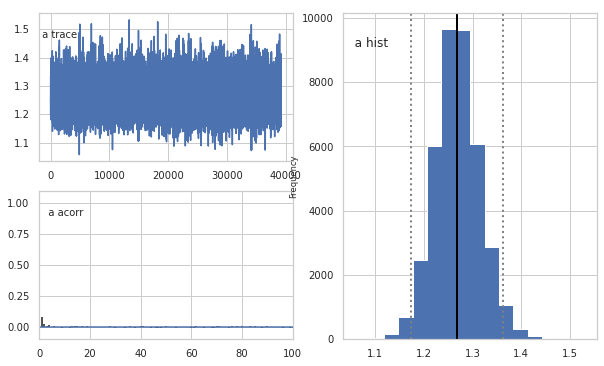

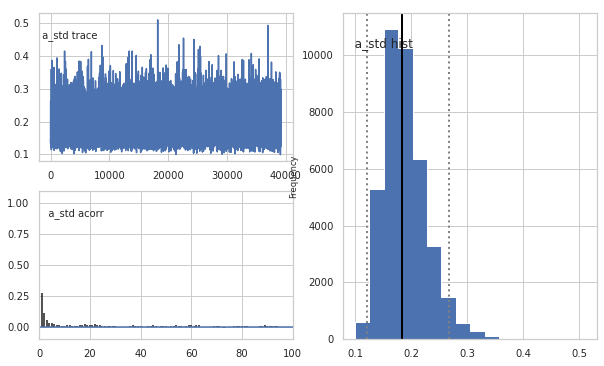

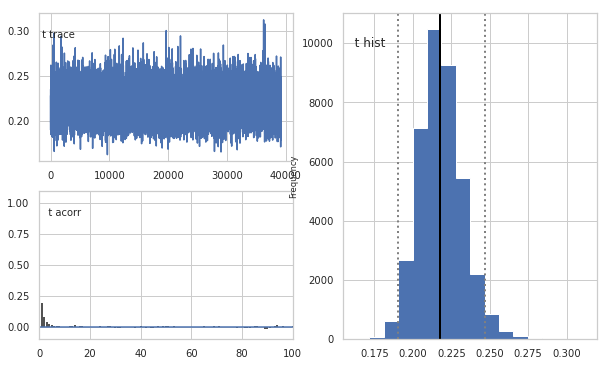

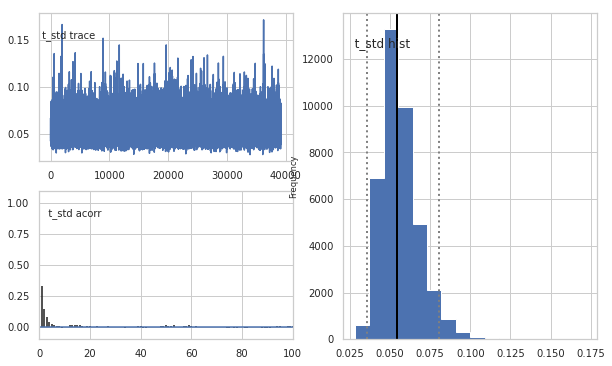

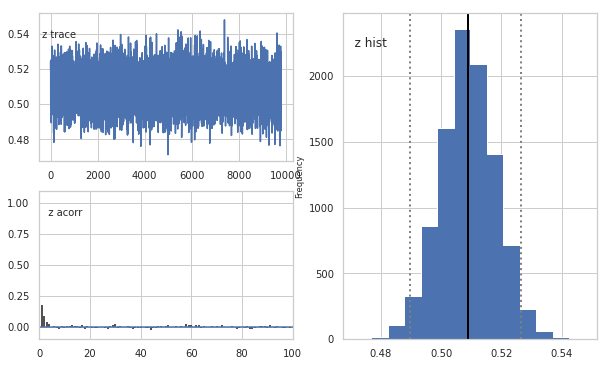

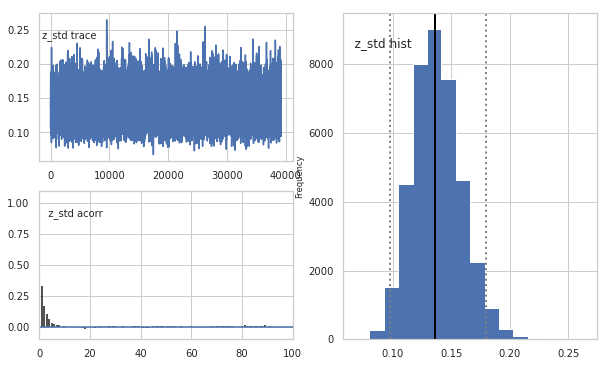

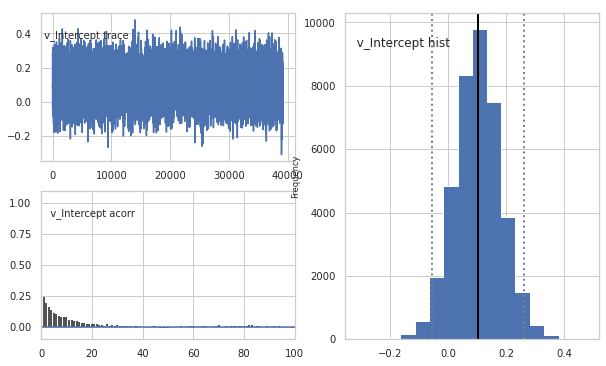

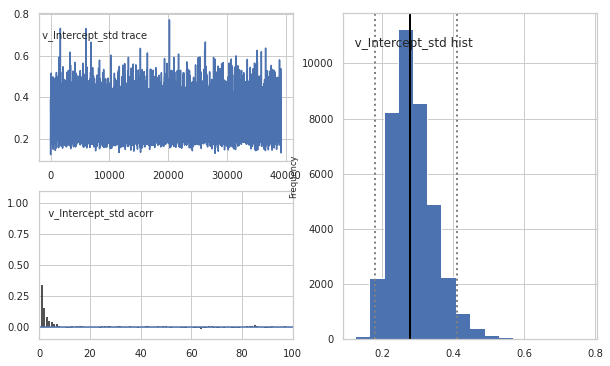

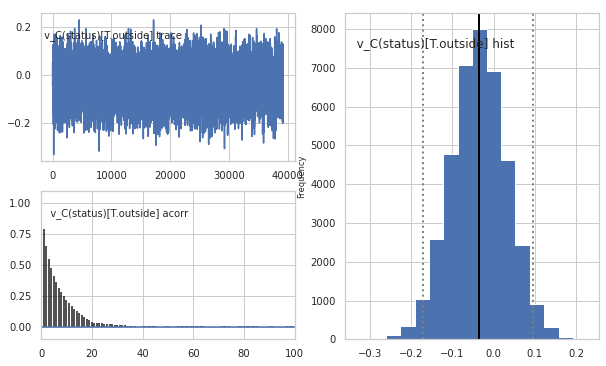

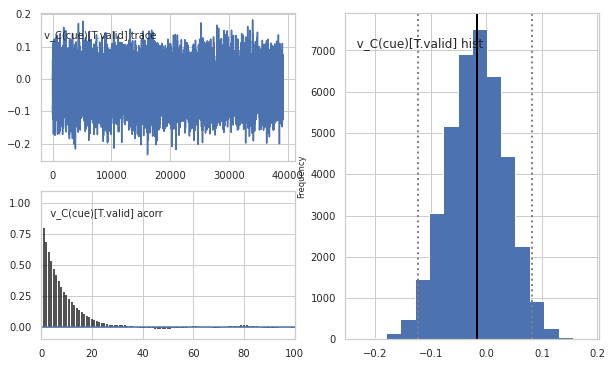

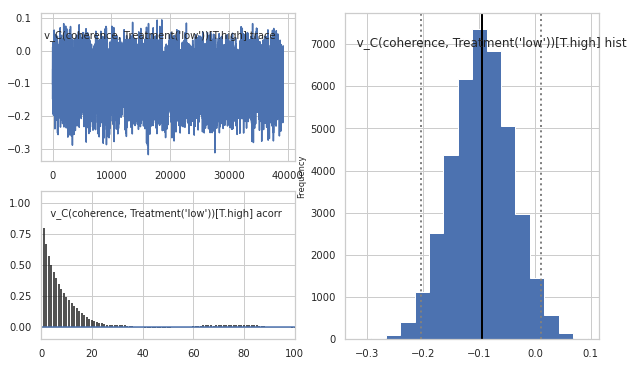

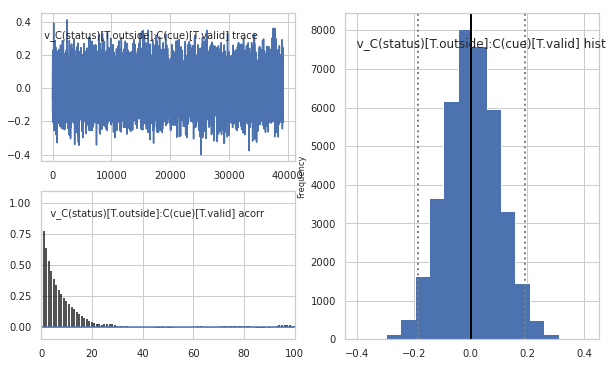

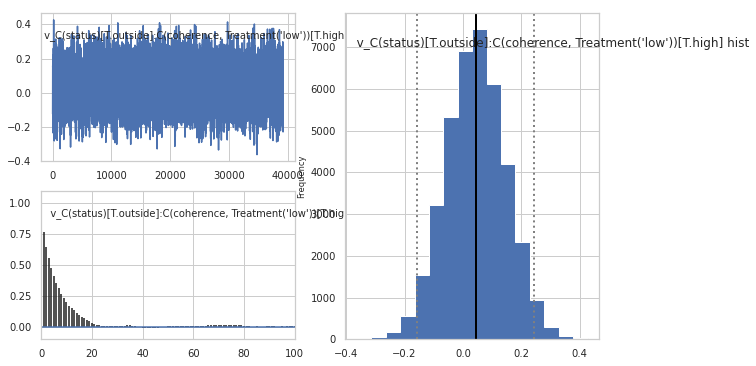

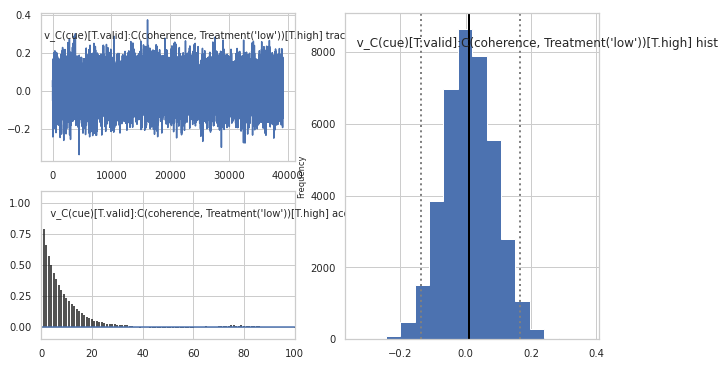

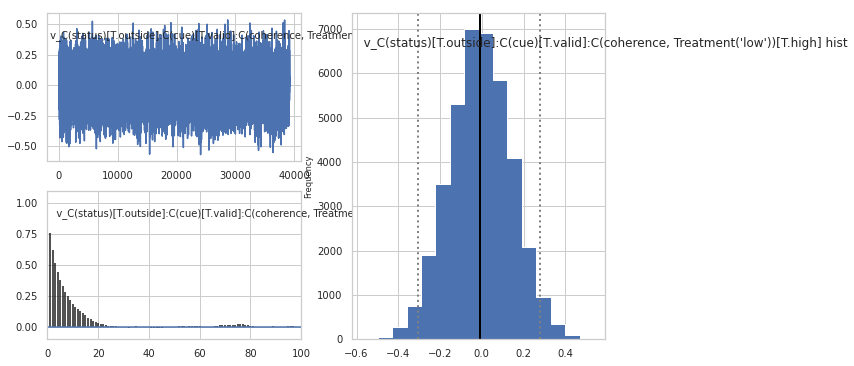

In [32]:
M1s_comb.plot_posteriors()

In [24]:
def plot_grp_trace(models, param=None):
    '''
    This function is to plot the traces of one of DDM params
    If param is None, than, will plot all the group parameters' posterior.
    '''
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    df_grp_traces = []
    for i in range(4):
        df_m = models[i]
        df_grp_trace = df_m.get_group_traces()
        df_grp_trace['chain'] = i
        print('chain', i, df_grp_trace.shape)
        df_grp_traces.append(df_grp_trace)
    df_grp_traces = pd.concat(df_grp_traces)
    
    # select the columns included that parameter
    if param is not None:
        filter_col = [col for col in df_grp_traces if col.startswith(param)]
        filter_col.append('chain') # add the chain column to the data
    else:
        filter_col = [col for col in df_grp_traces]
            
    
    #df_tmp = df_grp_traces[df_grp_traces.columns.intersection(filter_col)]
    df_tmp = df_grp_traces.loc[:,filter_col]
    df_tmp["sample_id"] = df_tmp.index
    
    df_melt = pd.melt(df_tmp,
                      id_vars=['sample_id', 'chain'],
                      value_vars=filter_col[:-1],
                      var_name='cond',
                      value_name='value')
    
    sns.set_palette("Set2")
    for indx, df_tmp in df_melt.groupby('cond'):

        fig, axs = plt.subplots(ncols=2,figsize=(20, 9))
        print(indx)

        sns.lineplot(x='sample_id', y='value', hue="chain", data=df_tmp, ax=axs[0], palette='Set2')
        
        sns.kdeplot(data=df_tmp, x="value", hue="chain", ax=axs[1], palette='Set2',
                    shade=False, linewidth=3)

        axs[0].set_title(indx, fontsize=20)
        #axs[1].set_xlim([0.5, 3])
        axs[1].set_title(indx, fontsize=20)
        plt.show()

chain 0 (15000, 23)
chain 1 (15000, 23)
chain 2 (15000, 23)
chain 3 (15000, 23)
a


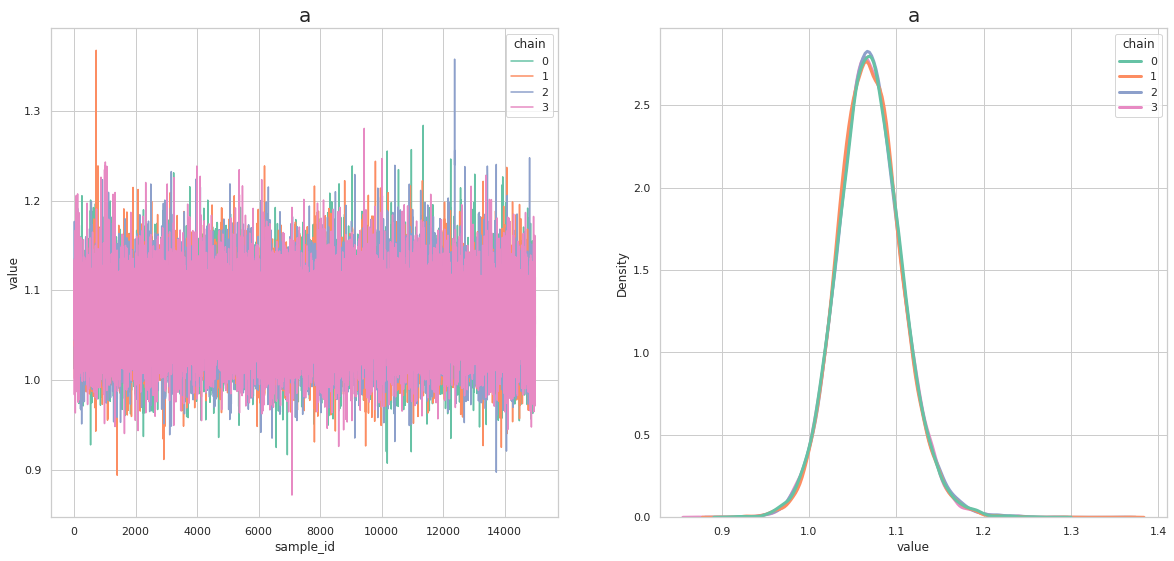

a_std


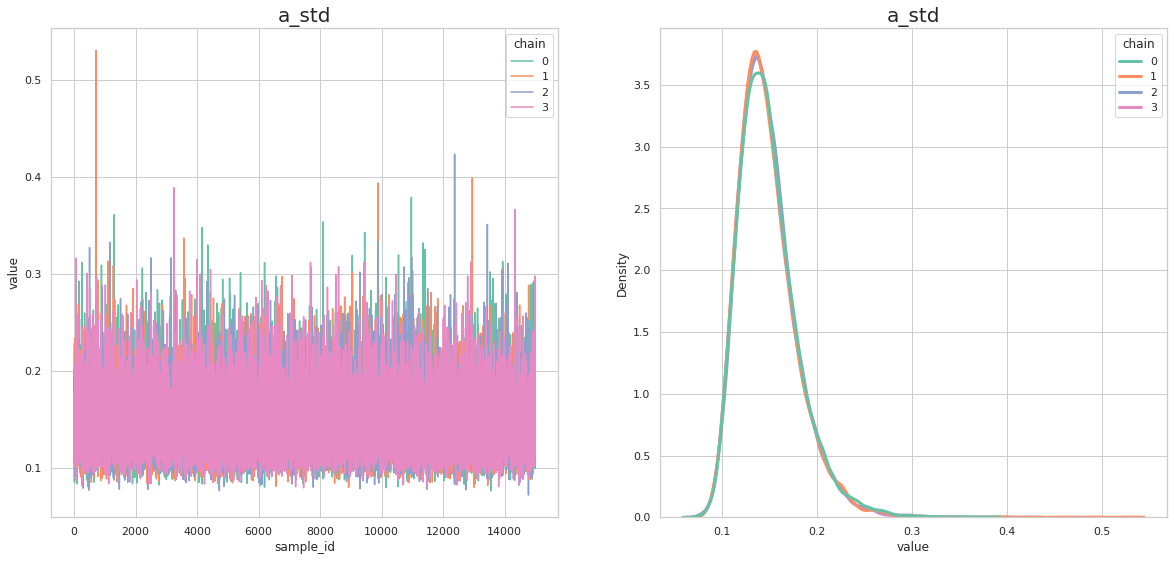

t_C(coherence, Treatment('low'))[T.high]


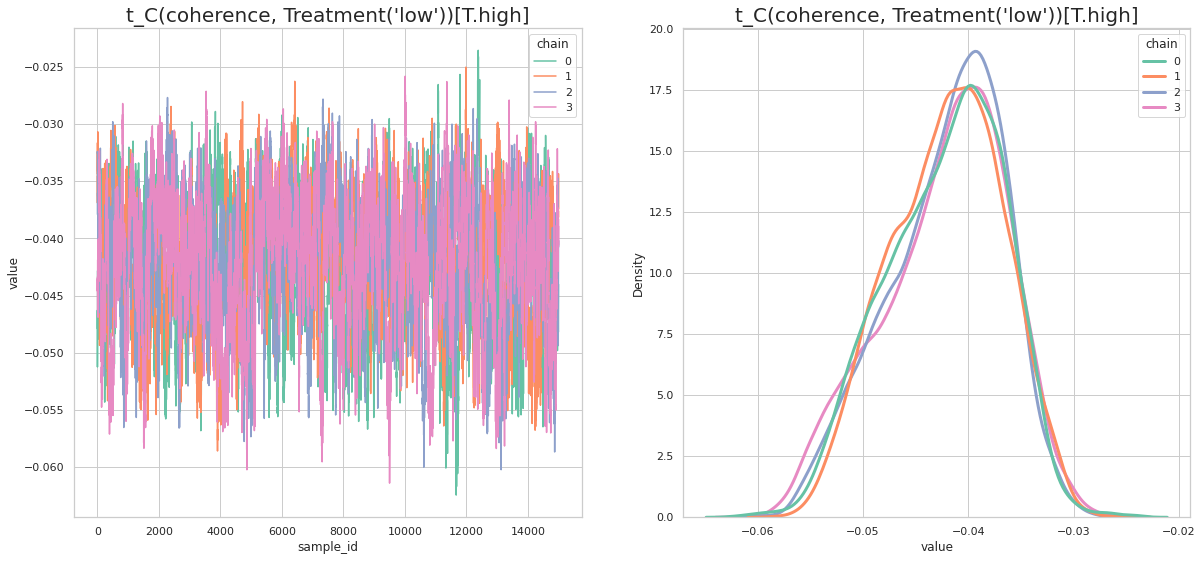

t_C(cue)[T.valid]


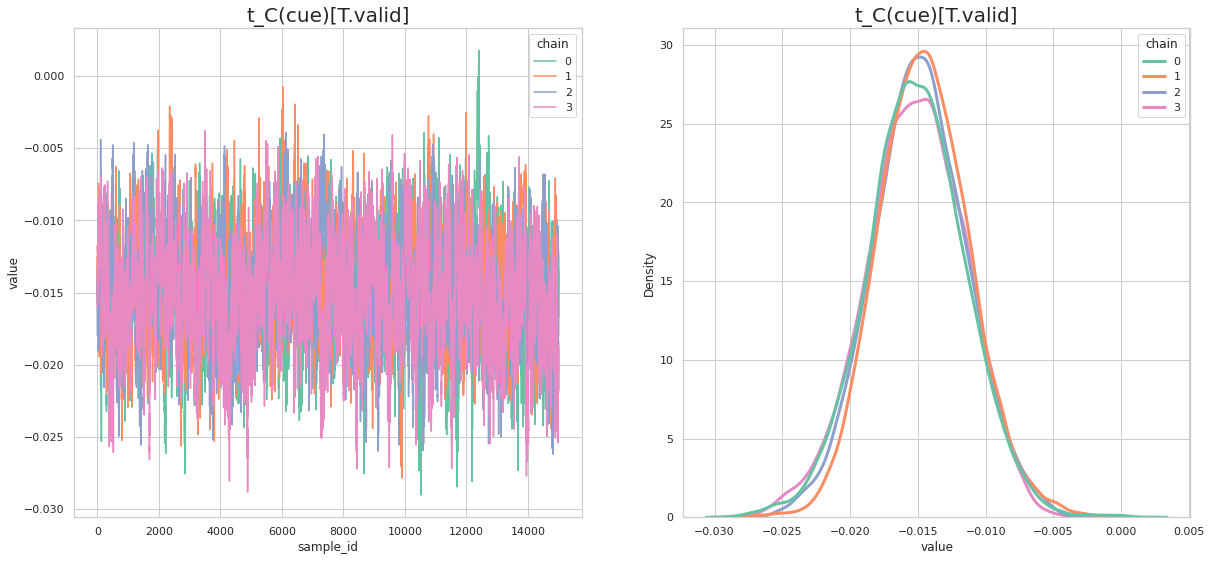

t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


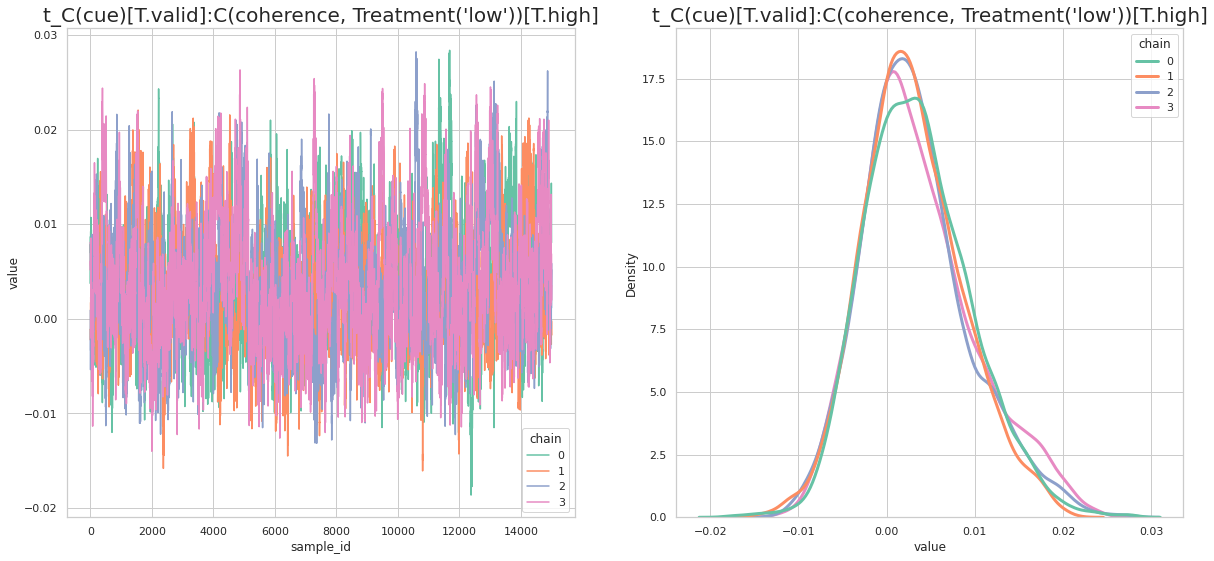

t_C(status)[T.outside]


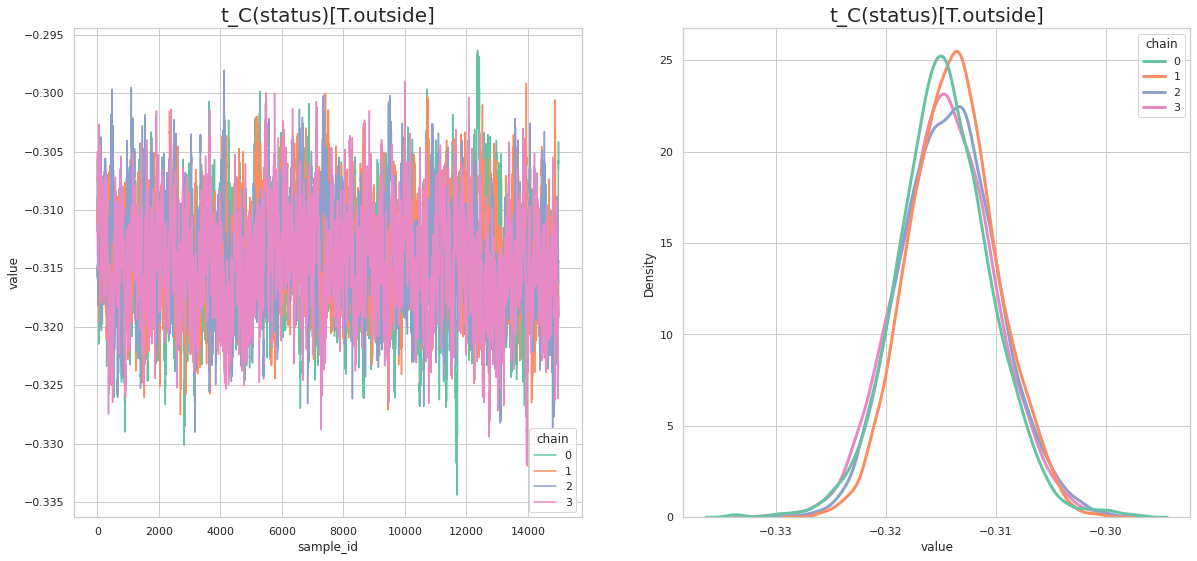

t_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]


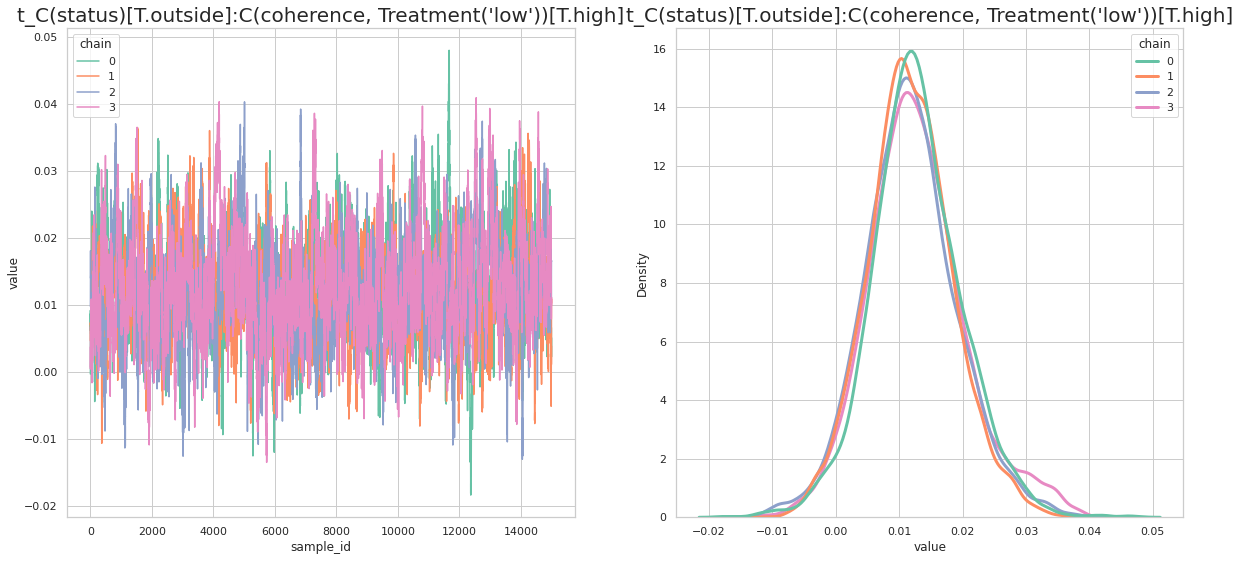

t_C(status)[T.outside]:C(cue)[T.valid]


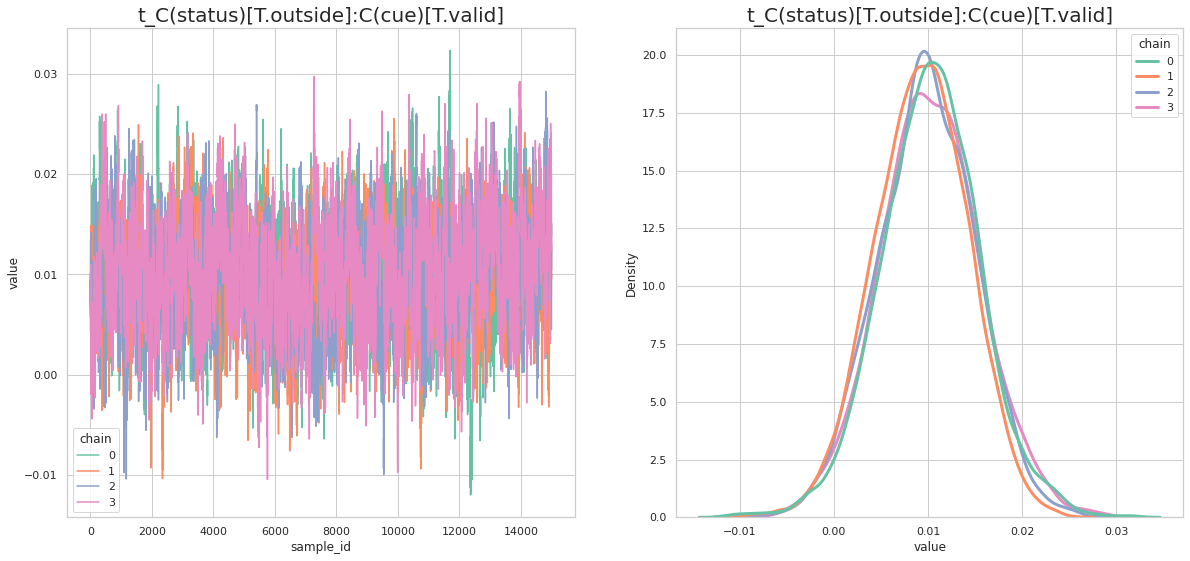

t_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


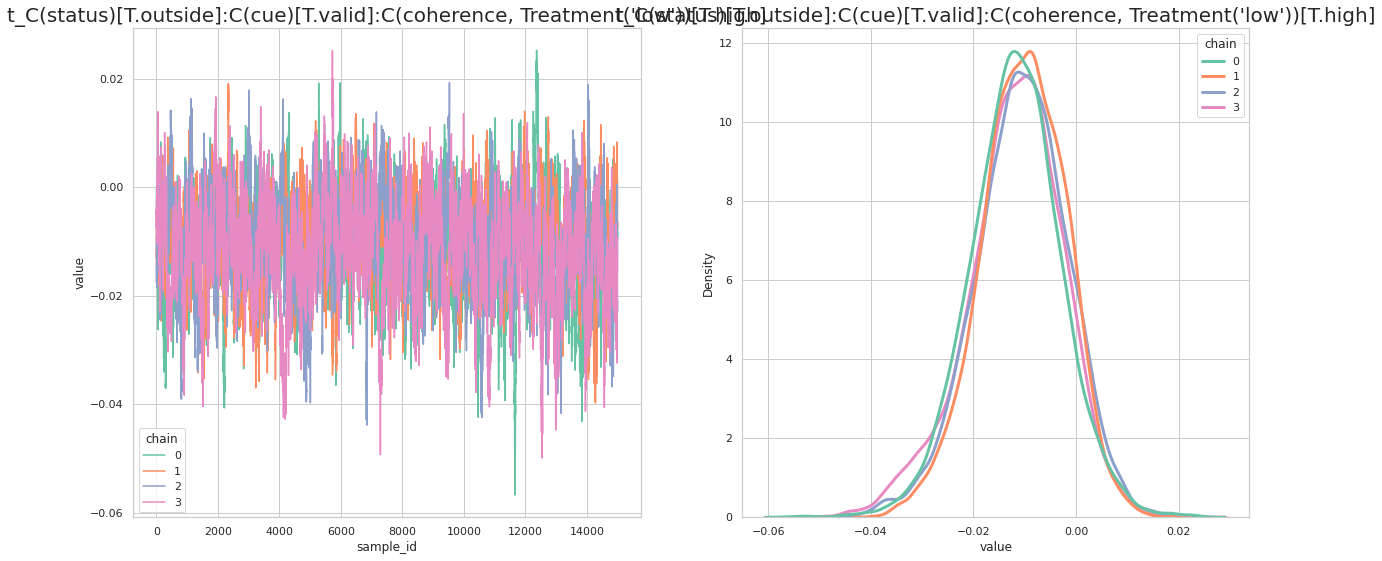

t_Intercept


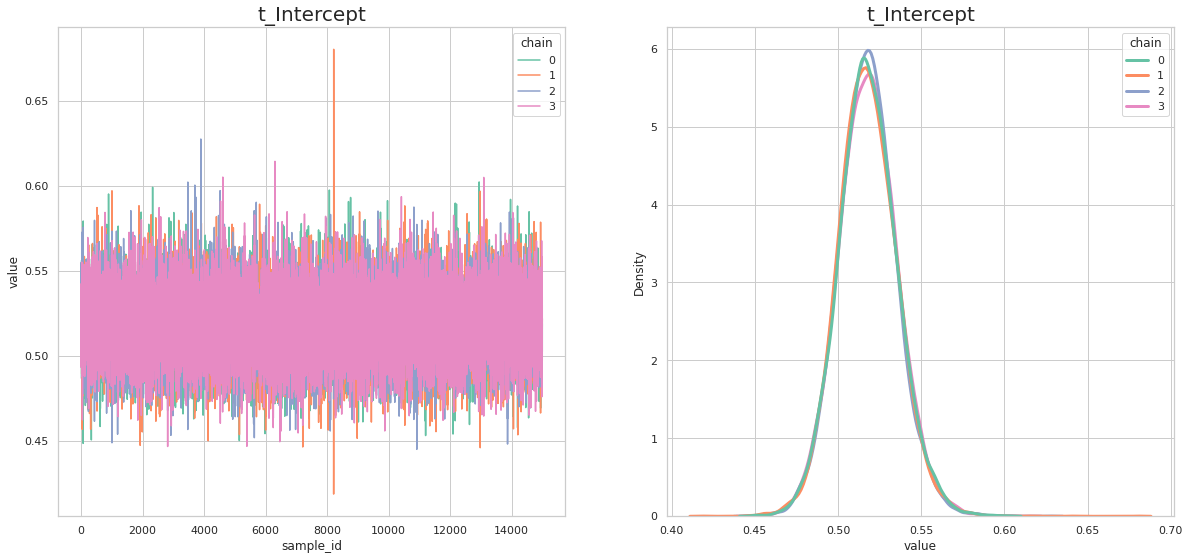

t_Intercept_std


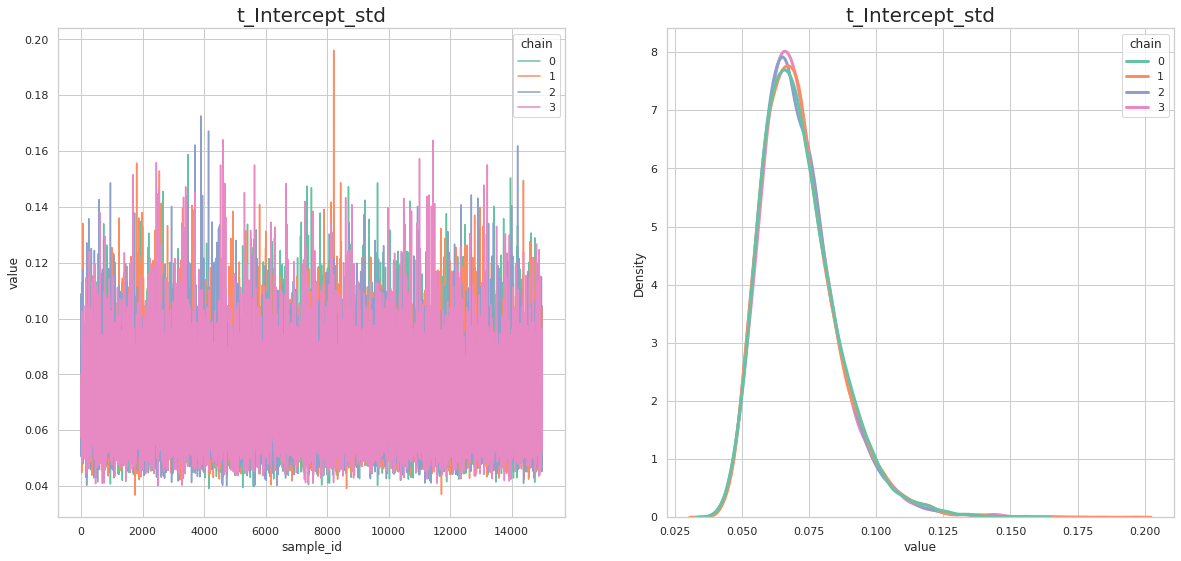

v_C(coherence, Treatment('low'))[T.high]


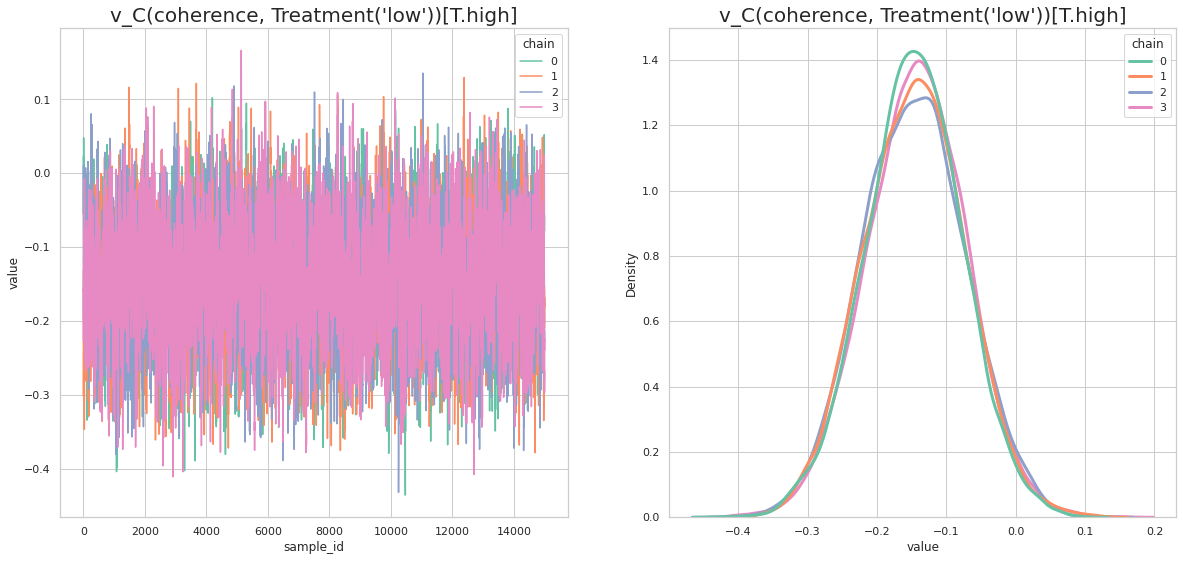

v_C(cue)[T.valid]


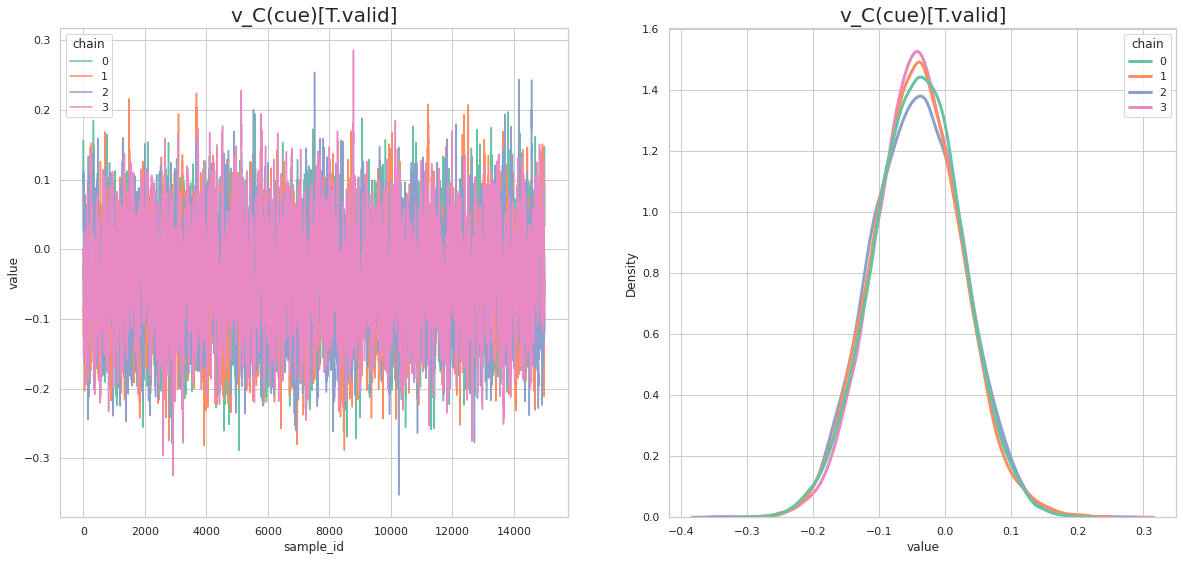

v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


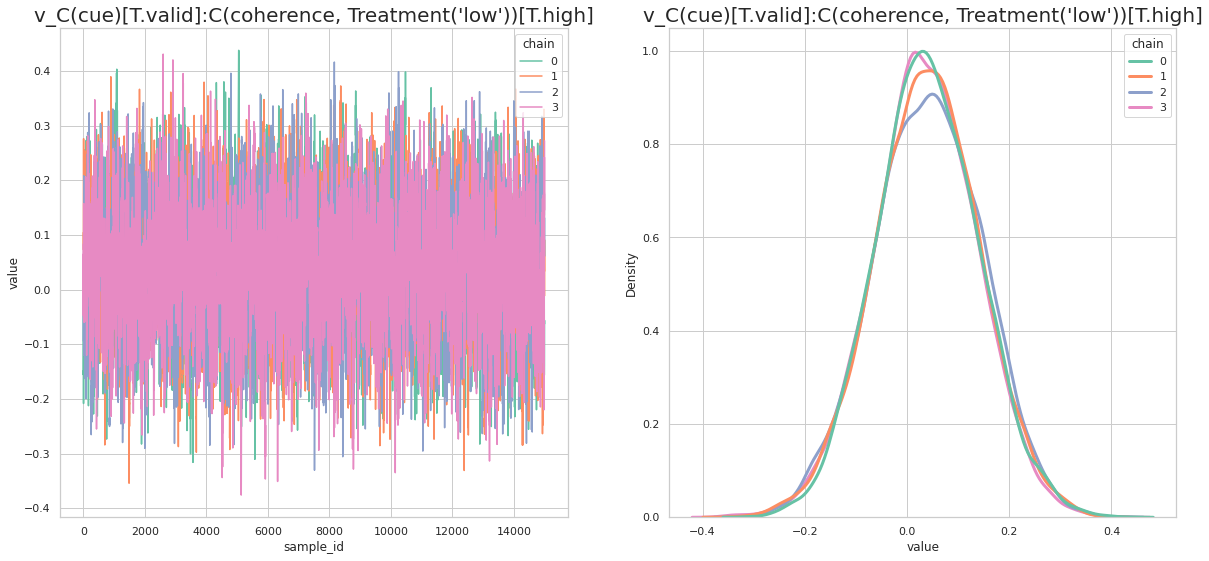

v_C(status)[T.outside]


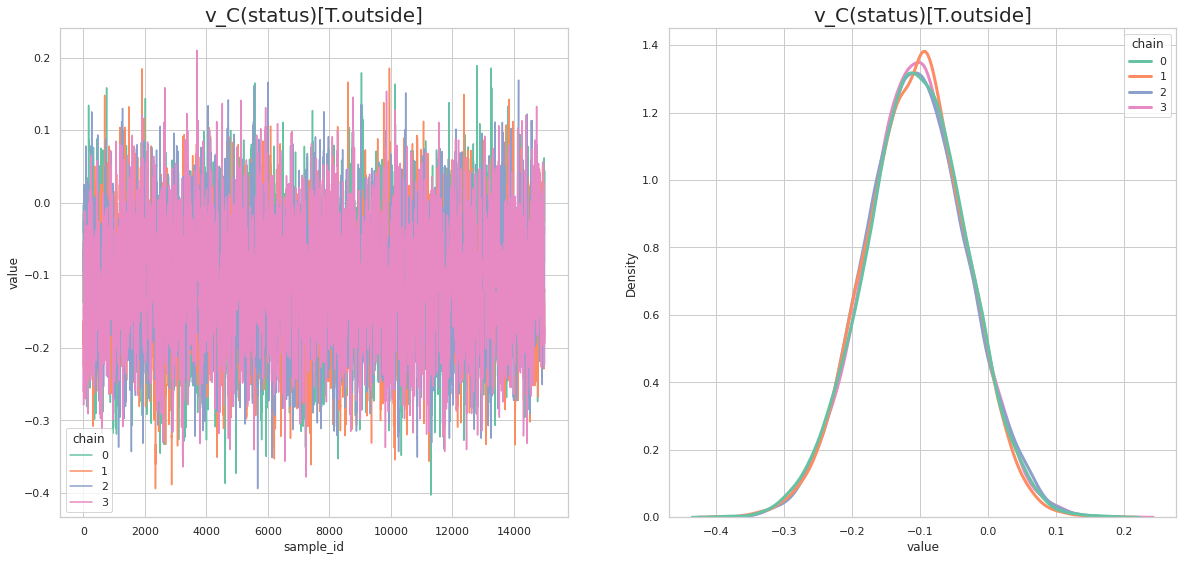

v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]


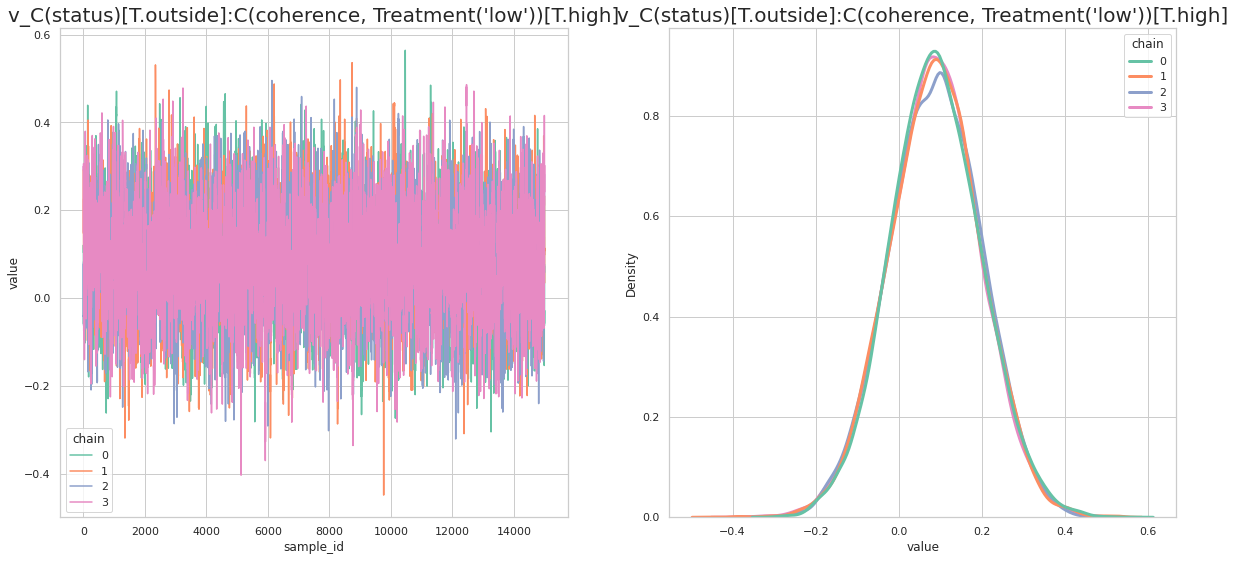

v_C(status)[T.outside]:C(cue)[T.valid]


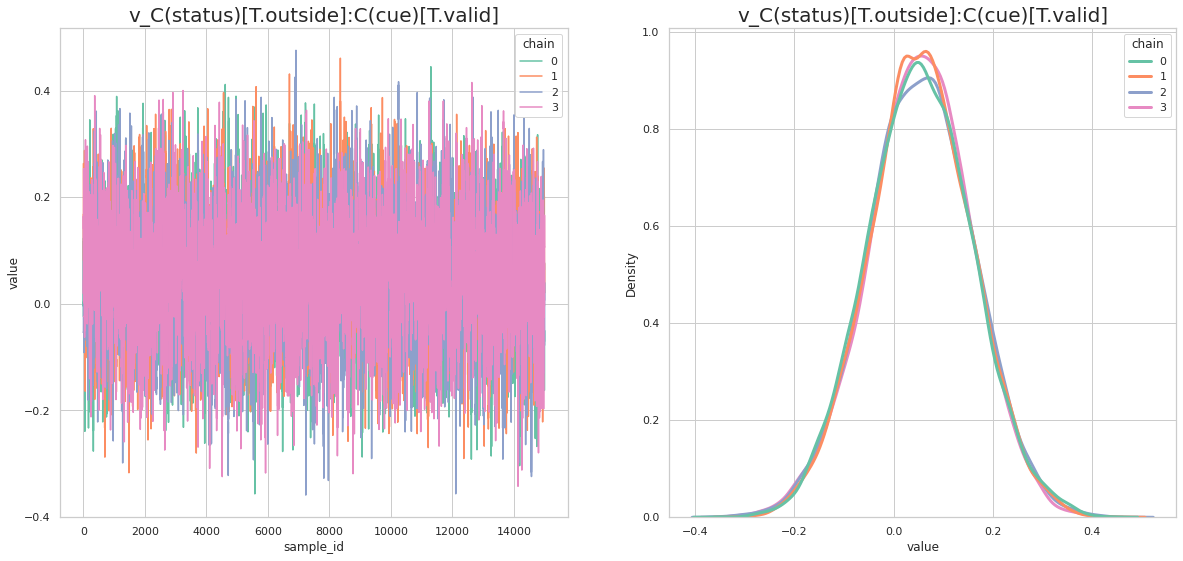

v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


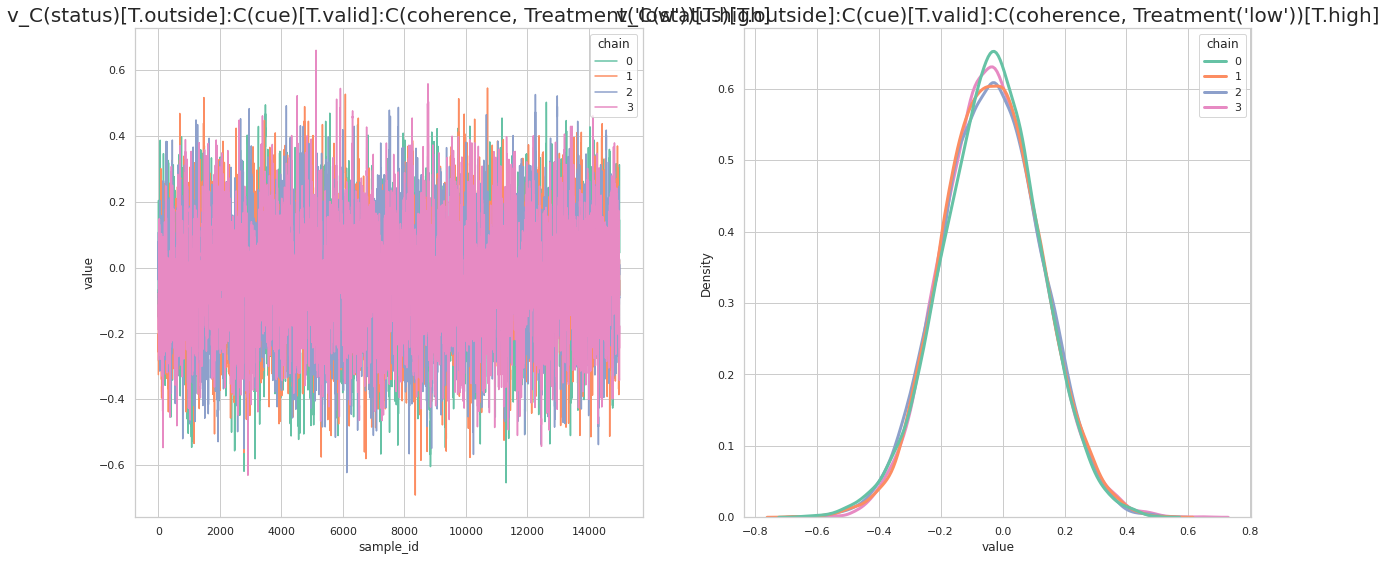

v_Intercept


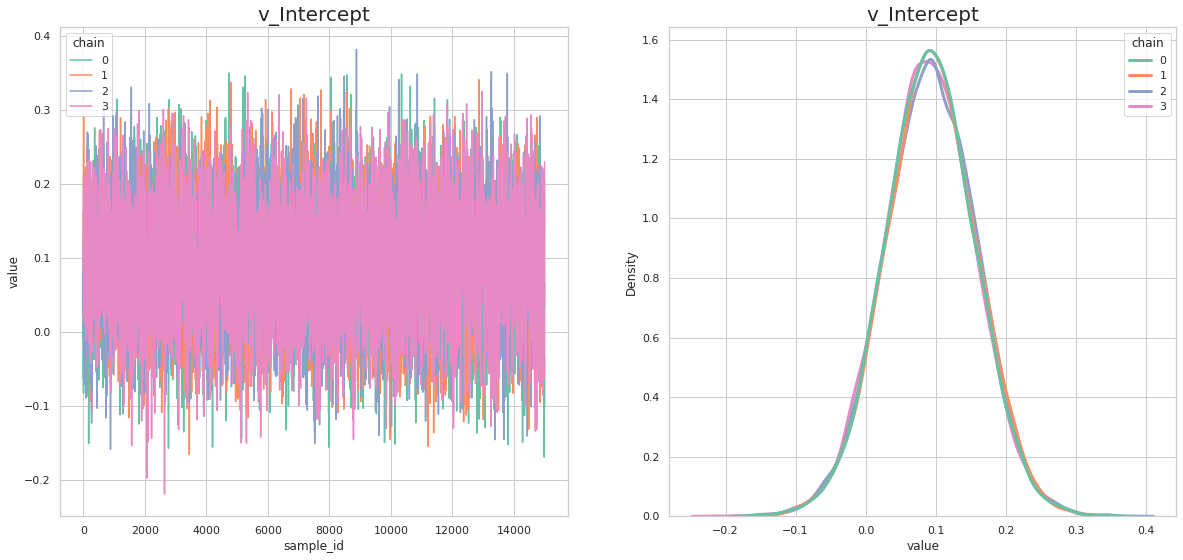

v_Intercept_std


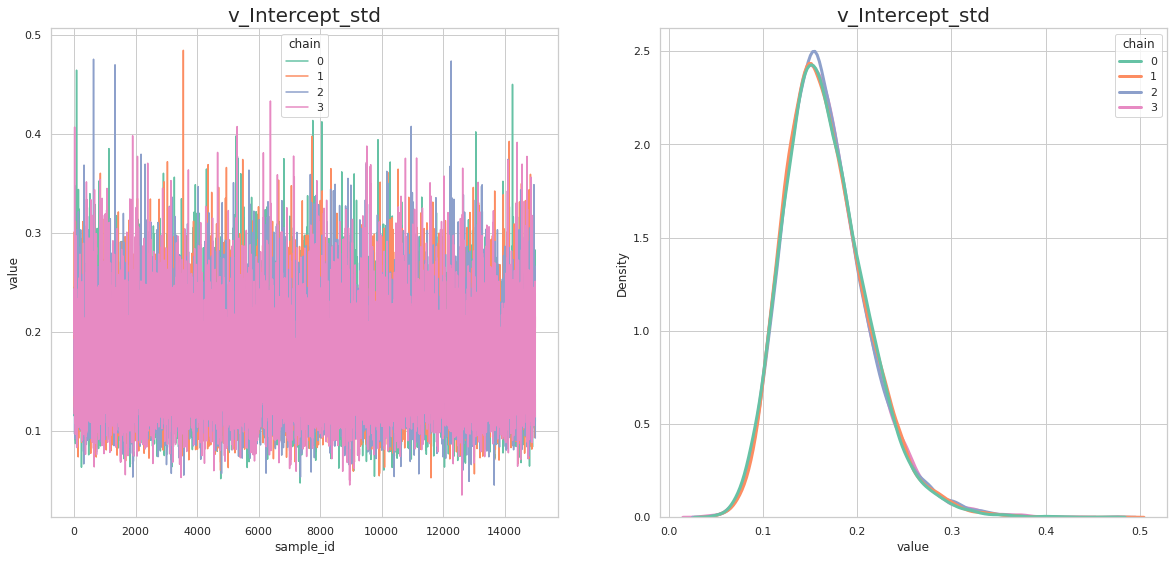

z_std


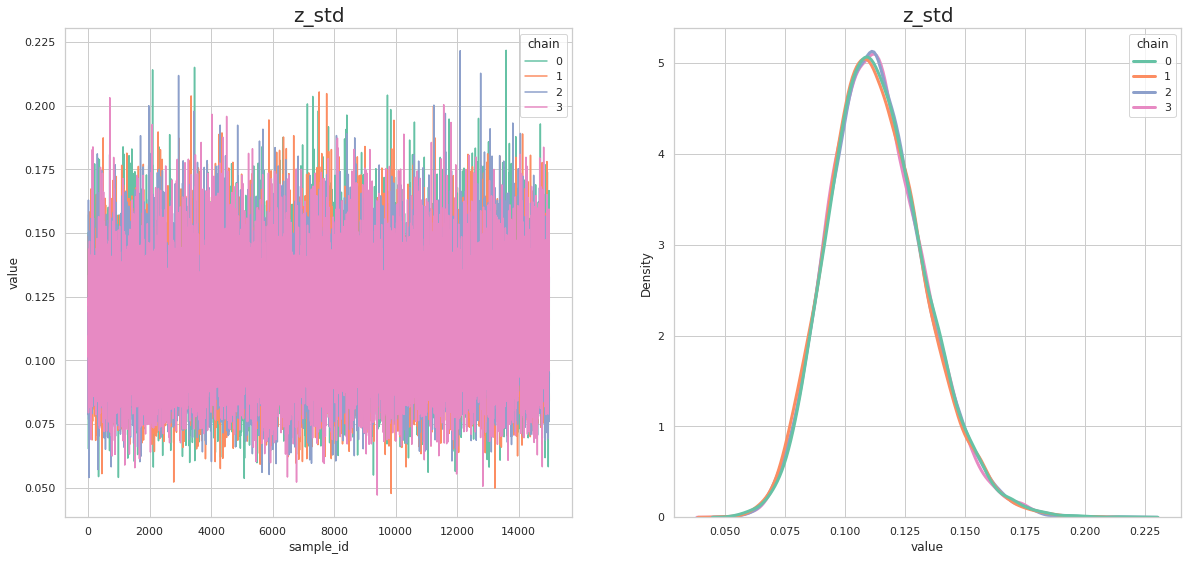

z_trans


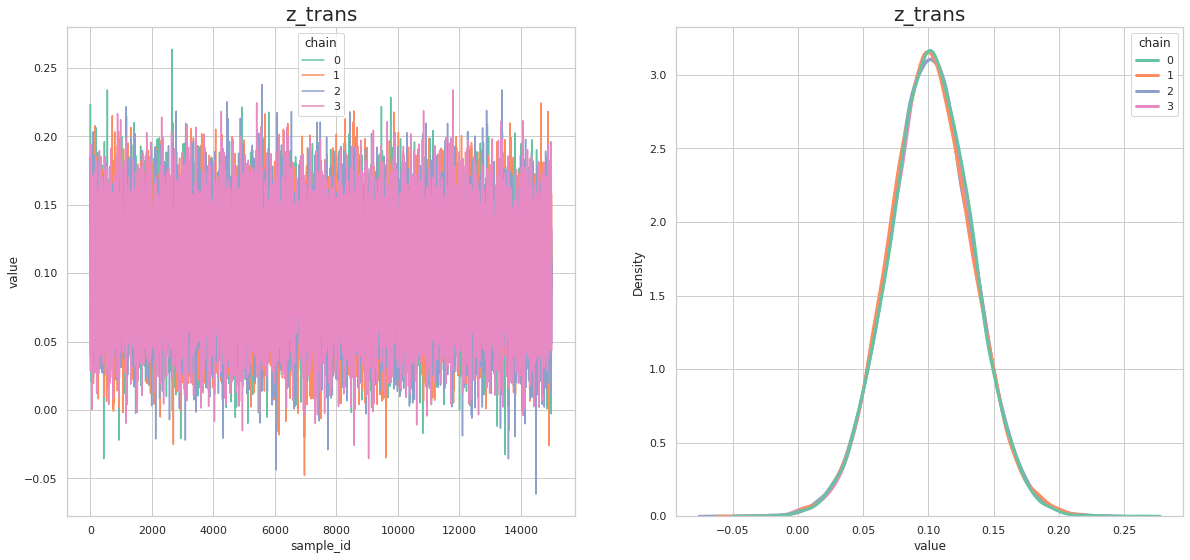

In [25]:
plot_grp_trace(models=M3s)

chain 0 (15000, 23)
chain 1 (15000, 23)
chain 2 (15000, 23)
chain 3 (15000, 23)
t_C(coherence, Treatment('low'))[T.high]


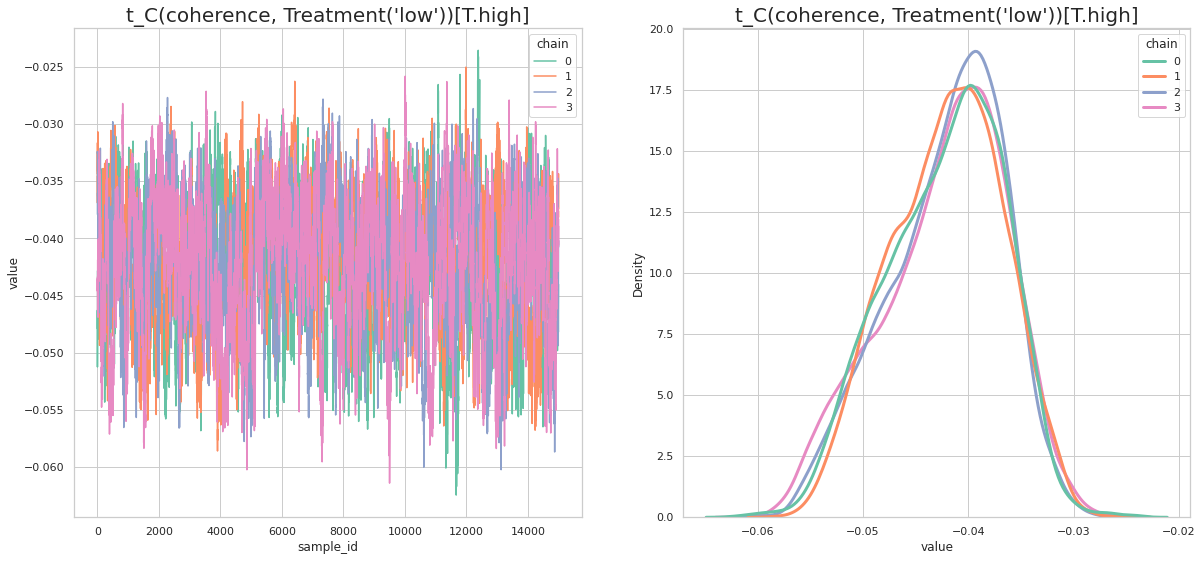

t_C(cue)[T.valid]


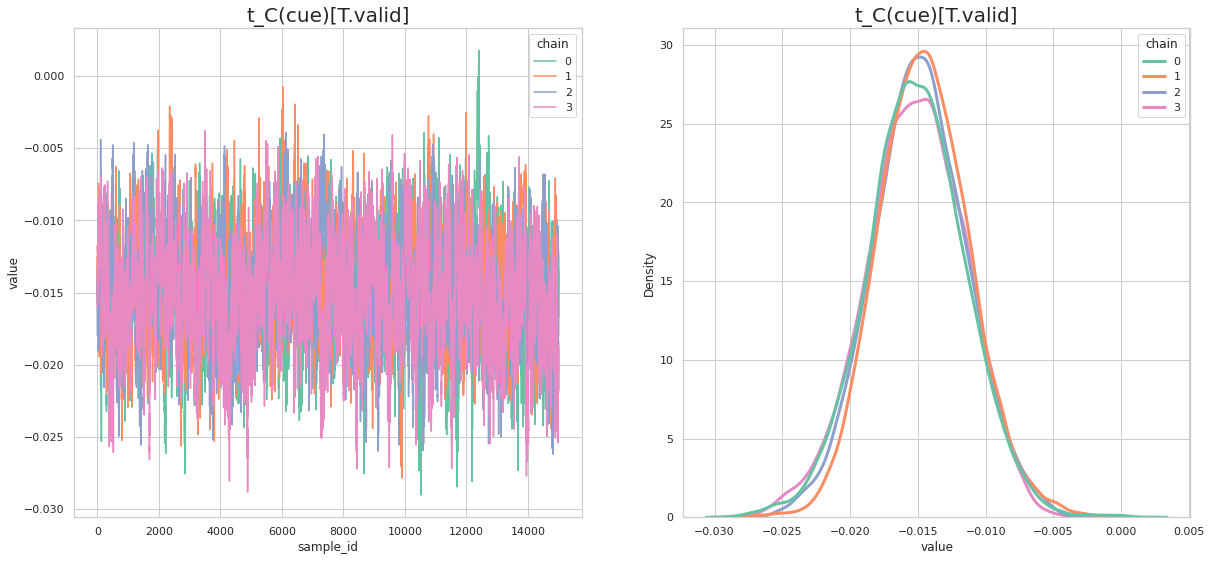

t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


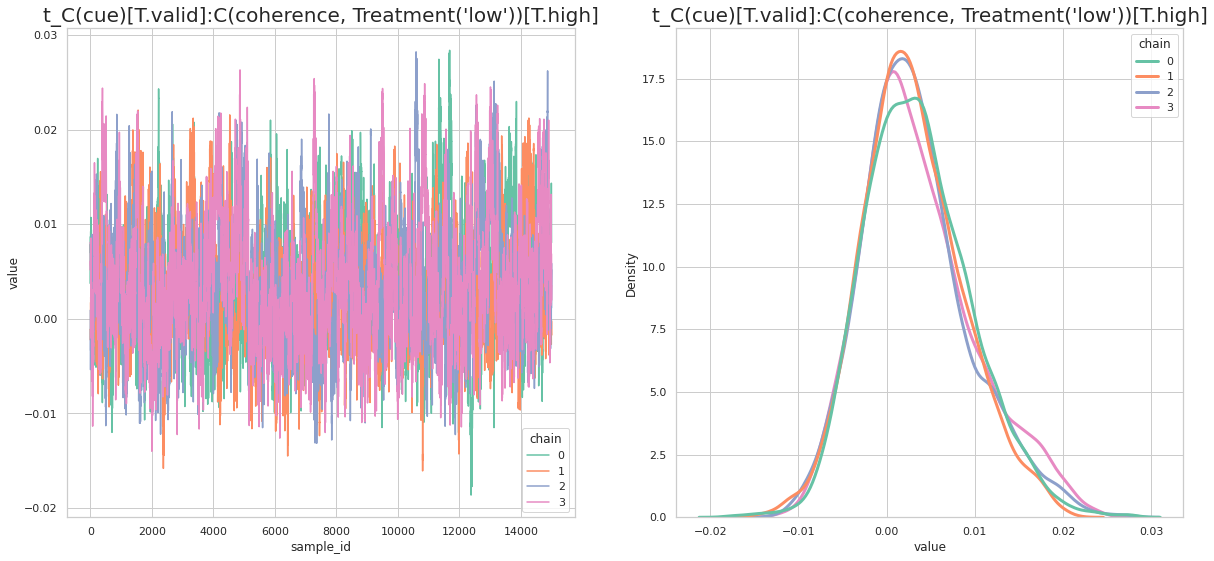

t_C(status)[T.outside]


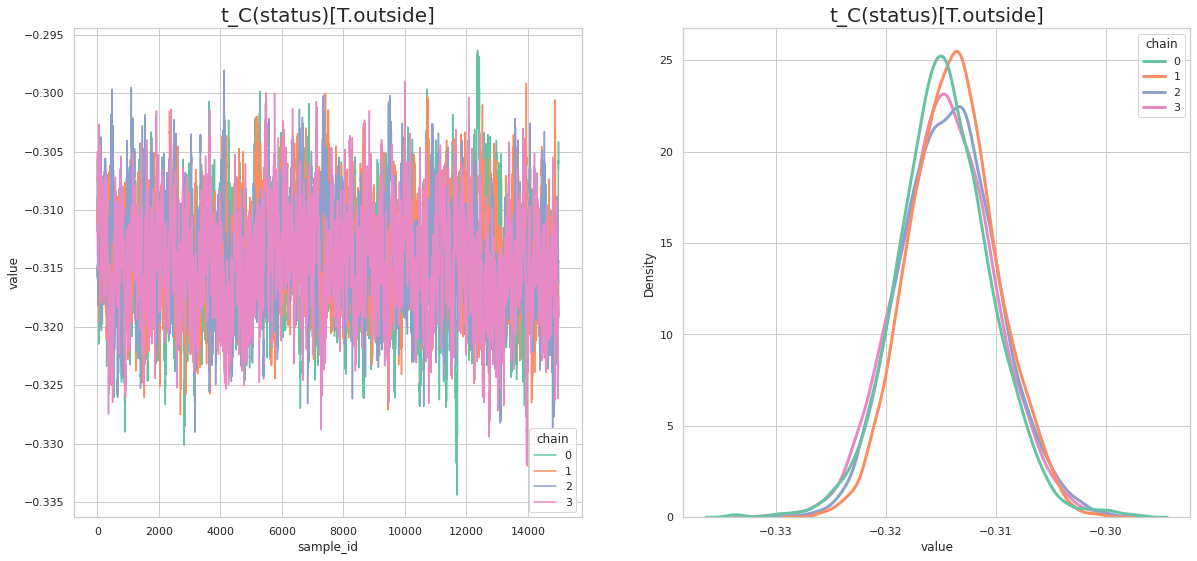

t_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]


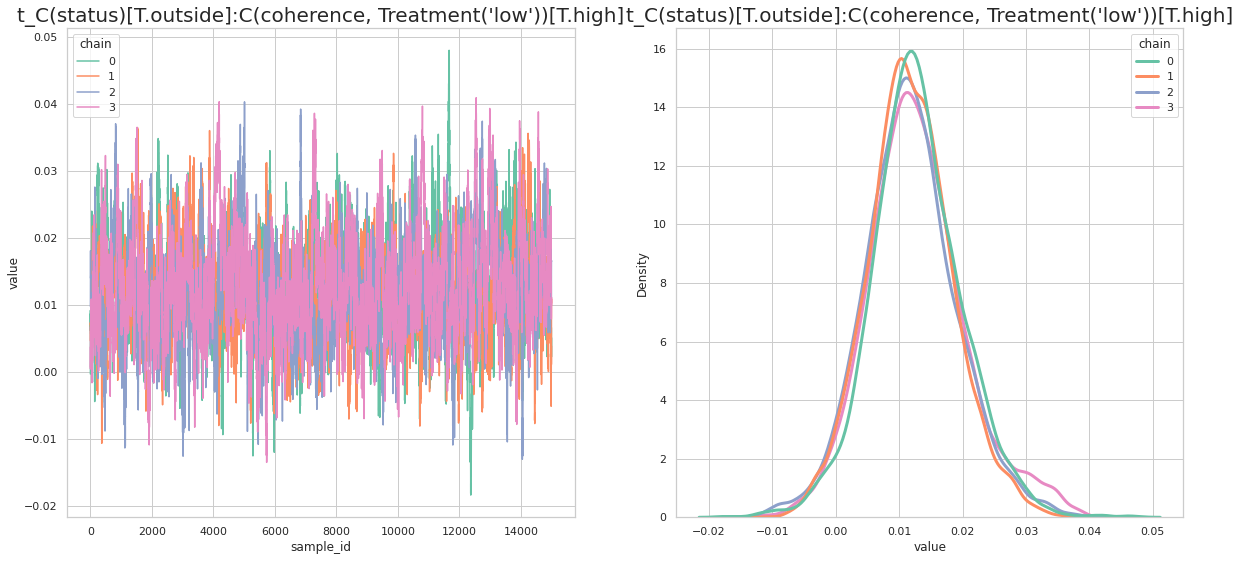

t_C(status)[T.outside]:C(cue)[T.valid]


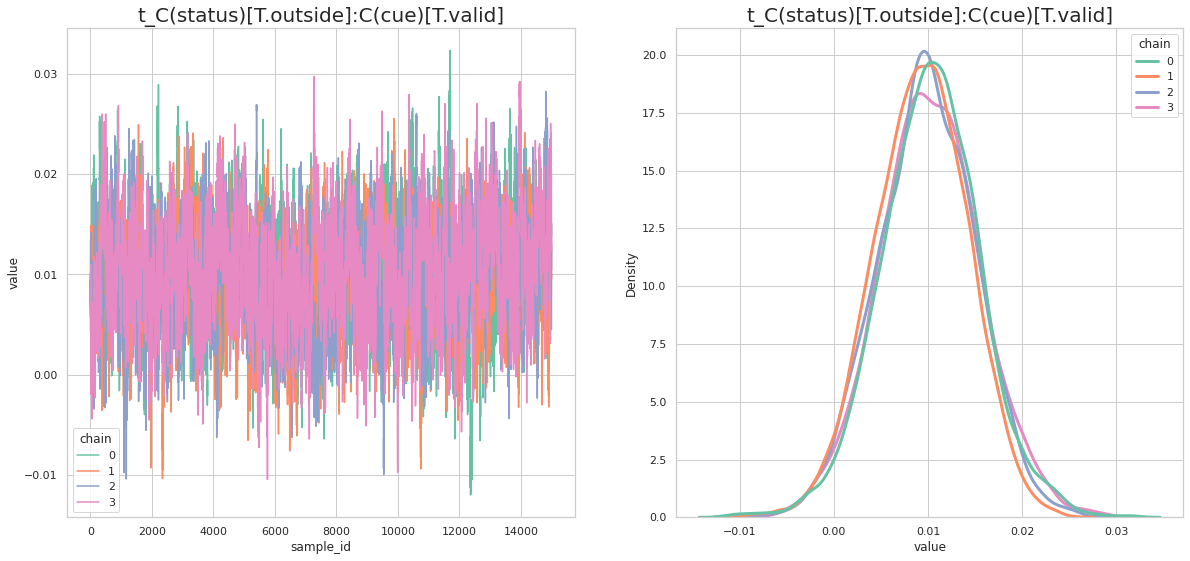

t_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]


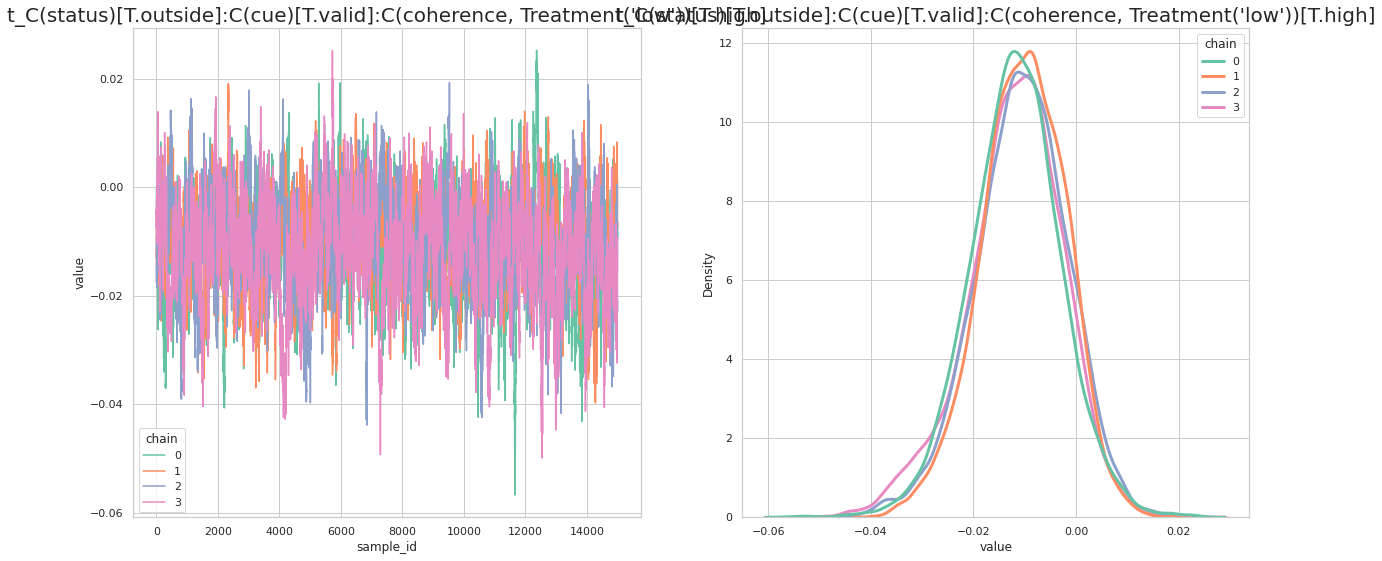

t_Intercept


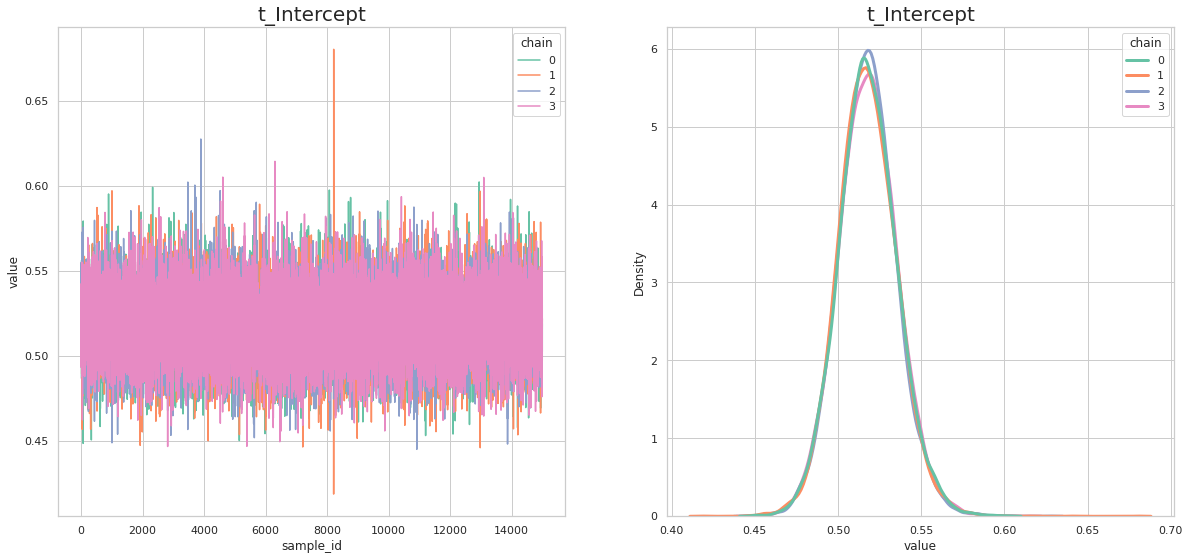

t_Intercept_std


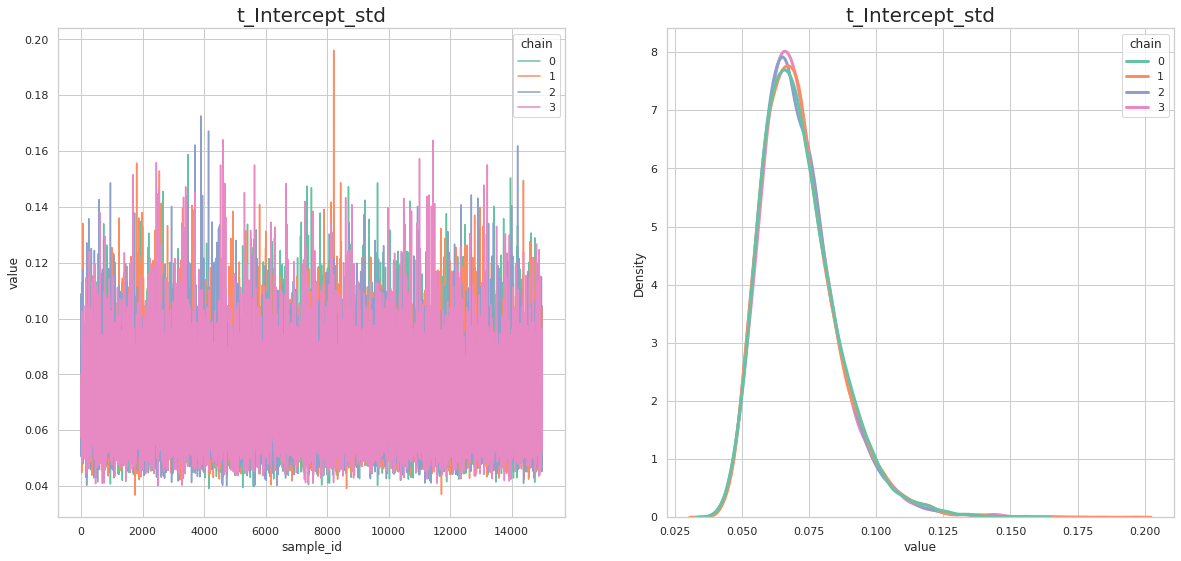

In [57]:
plot_grp_trace(models=M3s, param='t')

#### Posterior predictive analysis

In [27]:
M1s[0].plot_posterior_predictive()

<Figure size 576x432 with 0 Axes>

#### R-hat convergence statistic

In [28]:
M1s_r_hat = hddm.analyze.gelman_rubin(M1s)
M2s_r_hat = hddm.analyze.gelman_rubin(M2s)
M3s_r_hat = hddm.analyze.gelman_rubin(M3s)

# save Categ_R_hat_vtz
with open('M1s_r_hat.csv','w') as f:
    w = csv.writer(f)
    w.writerows(M1s_r_hat.items())
    
with open('M2s_r_hat.csv','w') as f:
    w = csv.writer(f)
    w.writerows(M2s_r_hat.items())
    
with open('M3s_r_hat.csv','w') as f:
    w = csv.writer(f)
    w.writerows(M3s_r_hat.items())

### Model comparison

Assume that all three models are convergent, now we need to compare these three models and decide which is the best model.

#### Deviance information criterion (DIC)

In [29]:
print("DIC of models 1: %f" % M1s_comb.dic)
print("DIC of models 2: %f" % M2s_comb.dic)
print("DIC of models 3: %f" % M3s_comb.dic)

DIC of models 1: 17118.067158
DIC of models 1: 8690.493477
DIC of models 1: 8695.295318


In [36]:
help(hddm.print_stats)

AttributeError: module 'hddm' has no attribute 'print_stats'

#### LOO and WAIC

loo & WAIC: https://discourse.pymc.io/t/calculating-waic-for-models-with-multiple-likelihood-functions/4834/2

data structure of ArviZ:
https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html#xarray-for-arviz

#### Posterior predictive check

In [30]:
ppc_data_1 = hddm.utils.post_pred_gen(M1s_comb)
ppc_data_2 = hddm.utils.post_pred_gen(M2s_comb)
ppc_data_3 = hddm.utils.post_pred_gen(M3s_comb)

 [--------------------117%--------------------] 20 of 17 complete in 15923.6 sec

In [35]:
ppc_compare_1 = hddm.utils.post_pred_stats(df, ppc_data_1)
ppc_compare_2 = hddm.utils.post_pred_stats(df, ppc_data_2)
ppc_compare_3 = hddm.utils.post_pred_stats(df, ppc_data_3)

In [36]:
print(ppc_compare_1)

          observed      mean       std           SEM       MSE credible  \
stat                                                                      
accuracy  0.524057  0.522710  0.056725  1.813414e-06  0.003220     True   
mean_ub   0.700034  0.640382  0.119173  3.558345e-03  0.017760     True   
std_ub    0.767739  0.365519  0.095701  1.617816e-01  0.170940    False   
10q_ub    0.303661  0.310702  0.066885  4.958226e-05  0.004523     True   
30q_ub    0.458311  0.408699  0.076457  2.461327e-03  0.008307     True   
50q_ub    0.593837  0.530766  0.096973  3.977958e-03  0.013382     True   
70q_ub    0.716727  0.716190  0.137167  2.874083e-07  0.018815     True   
90q_ub    1.002137  1.113767  0.234958  1.246128e-02  0.067666     True   
mean_lb  -0.710871 -0.652258  0.134483  3.435528e-03  0.021521     True   
std_lb    0.721856  0.366662  0.097286  1.261632e-01  0.135627    False   
10q_lb    0.305616  0.318381  0.077302  1.629651e-04  0.006139     True   
30q_lb    0.448136  0.419

In [37]:
print(ppc_compare_2)

          observed      mean       std           SEM       MSE credible  \
stat                                                                      
accuracy  0.524057  0.523232  0.051710  6.810688e-07  0.002675     True   
mean_ub   0.700034  0.632844  0.113957  4.514473e-03  0.017501     True   
std_ub    0.767739  0.276927  0.064724  2.408965e-01  0.245086    False   
10q_ub    0.303661  0.307495  0.081086  1.470270e-05  0.006590     True   
30q_ub    0.458311  0.481393  0.094801  5.327502e-04  0.009520     True   
50q_ub    0.593837  0.601517  0.096341  5.897530e-05  0.009341     True   
70q_ub    0.716727  0.721275  0.123532  2.069183e-05  0.015281     True   
90q_ub    1.002137  0.978842  0.190761  5.426853e-04  0.036933     True   
mean_lb  -0.710871 -0.653820  0.131192  3.254778e-03  0.020466     True   
std_lb    0.721856  0.279723  0.066800  1.954823e-01  0.199945    False   
10q_lb    0.305616  0.324116  0.093946  3.422495e-04  0.009168     True   
30q_lb    0.448136  0.500

In [38]:
print(ppc_compare_3)

          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.524057  0.522070  0.051482  0.000004  0.002654     True   
mean_ub   0.700034  0.634719  0.113853  0.004266  0.017229     True   
std_ub    0.767739  0.276653  0.064358  0.241166  0.245308    False   
10q_ub    0.303661  0.308578  0.081179  0.000024  0.006614     True   
30q_ub    0.458311  0.485779  0.094004  0.000754  0.009591     True   
50q_ub    0.593837  0.603288  0.096551  0.000089  0.009411     True   
70q_ub    0.716727  0.722550  0.123750  0.000034  0.015348     True   
90q_ub    1.002137  0.980660  0.190752  0.000461  0.036847     True   
mean_lb  -0.710871 -0.651530  0.129972  0.003521  0.020414     True   
std_lb    0.721856  0.279599  0.066544  0.195592  0.200019    False   
10q_lb    0.305616  0.322897  0.093199  0.000299  0.008985     True   
30q_lb    0.448136  0.496383  0.107026  0.002328  0.013782     True   
50q_lb

#### Plot the posterior prediction (w/ the observed data)

In [39]:
M3s[0].print_stats()

                                                                                     mean         std         2.5q          25q          50q         75q       97.5q       mc err
a                                                                                 1.06979   0.0374056     0.998346      1.04531      1.06884     1.09333     1.14629  0.000381268
a_std                                                                             0.14883   0.0315315      0.10224     0.126825     0.144252    0.165285     0.22438  0.000381003
a_subj.1                                                                         0.900445    0.026135     0.851788     0.882578     0.899798    0.917624    0.953755  0.000474443
a_subj.2                                                                         0.975566    0.025883     0.927183     0.957832     0.974822    0.992477     1.02801    0.0004314
a_subj.3                                                                           1.0615    0.021472      1.0

### Interepreting parameters and inference

Now assume that we get the best fitted model (M3), and we will then make statistical inference based on that model.

How to interprete the effect based on experimental design is beyond the scope of current primer. Essentially, the `HDDMRegressor` module is bulding a hierarchical model, therefore, interested readers and refer some article on linear regression with categorical vairable and their intereactions. (e.g., a blogpost [here](https://genomicsclass.github.io/book/pages/interactions_and_contrasts.html))

In the current models, we Let's look at the experimental design and the model again:

The experimental design is 2 by 2 by 2, thus 8 conditions, the models is:

---
For model without interaction:

* $v \sim cue + coherence + status, t \sim cue + coherence + status$

Thus for both `v` and `t`, we have intercept and three main effect. Because we did not include interaction terms, we are assuming that  the effects are additive.

To get the estimation for each condition, we need to use the available estimates to calculate the conditions.


`t_intercept`: Inside + invalid + high

`t_intercept` + `t_C(status)[T.outside]`: **Outside** + invalid + high

`t_intercept` + `t_C(cue)[T.valid]`: Inside + **valid** + high

`t_intercept` + `t_C(cue)[T.valid]` + `t_C(status)[T.outside]`: **Outside** + **valid** + high

`t_intercept` + `t_C(coherence)[T.low]`: Inside + invalid + **low**

`t_intercept` + `t_C(coherence)[T.low]` + `t_C(status)[T.outside]`: **Outside** + invalid + **low**

`t_intercept` + `t_C(coherence)[T.low]` + `t_C(cue)[T.valid]`: Inside + **valid** + **low**

`t_intercept` + `t_C(coherence)[T.low]`+ `t_C(cue)[T.valid]` + `t_C(status)[T.outside]`: **Outside** + **valid** + **low**

---


---
For model with interaction:

* $v \sim cue * coherence (Treatment('low'))* status$
* $t \sim cue * coherence(Treatment('low')) * status$

Thus for both `v` and `t`, we have intercept and three main effect. Because we did not include interaction terms, we are assuming that  the effects are additive.

To get the estimation for each condition, we need to use the available estimates to calculate the conditions.


`t_intercept`: Inside + invalid + low

`t_intercept` + `t_C(coherence, Treatment('low'))[T.high]`: Inside + invalid + **high**

`t_intercept` + `t_C(status)[T.outside]`: **Outside** + invalid + low

`t_intercept` + `t_C(cue)[T.valid]`: Inside + **valid** + low


`t_intercept` + `t_C(cue)[T.valid]` + `t_C(status)[T.outside]` + `t_C(status)[T.outside]:C(cue)[T.valid] `: **Outside** + **valid** + low

`t_intercept` + `t_C(coherence, Treatment('low'))[T.high]` + `t_C(status)[T.outside]` + `t_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high] `: **Outside** + invalid + **high**

`t_intercept` + `t_C(coherence, Treatment('low'))[T.high]` + `t_C(cue)[T.valid]` + `t_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]`: Inside + **valid** + **high**

`t_intercept` + `t_C(coherence, Treatment('low'))[T.high]`+ `t_C(cue)[T.valid]` + `t_C(status)[T.outside]` + `t_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]`: **Outside** + **valid** + **high**

---

In [40]:
df_grp_traces = []
for i in range(4):
    df_m = M3s[i]
    df_grp_trace = df_m.get_group_traces()
    df_grp_trace['chain'] = i
    print('chain', i, df_grp_trace.shape)
    df_grp_traces.append(df_grp_trace)
    
df_grp_traces = pd.concat(df_grp_traces)

# select the columns included that parameter
filter_col = [col for col in df_grp_traces if col.startswith('v')] # filter column names contains v
# filter_col = [col for col in df_grp_traces_m1 if 'std' not in col] # filter column names contains v

filter_col = [col for col in filter_col if 'std' not in col] # filter the std column

filter_col.append('chain') # add the chain column to the data

#df_tmp = df_grp_traces[df_grp_traces.columns.intersection(filter_col)]
df_tmp = df_grp_traces.loc[:, filter_col]
df_tmp["sample_id"] = df_tmp.index

df_tmp.head()

chain 0 (15000, 23)
chain 1 (15000, 23)
chain 2 (15000, 23)
chain 3 (15000, 23)


v_Intercept  v_C(status)[T.outside]  v_C(cue)[T.valid]  \
0    -0.062468               -0.053487           0.098591   
1    -0.007200               -0.114474           0.156211   
2    -0.028582               -0.122924           0.102577   
3     0.017700               -0.138362           0.089363   
4    -0.083093               -0.002991           0.097507   

   v_C(coherence, Treatment('low'))[T.high]  \
0                                  0.022564   
1                                  0.022045   
2                                 -0.054772   
3                                 -0.055203   
4                                 -0.051199   

   v_C(status)[T.outside]:C(cue)[T.valid]  \
0                                0.003570   
1                               -0.004450   
2                                0.018532   
3                                0.120489   
4                                0.123399   

   v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]  \
0                                           0.103568               
1                                           0.090007               
2                                           0.120733               
3                                           0.083329               
4                                          -0.058702               

   v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]  \
0                                          -0.148528          
1                                          -0.156008          
2                                          -0.116764          
3                                          -0.125658          
4                                          -0.011792          

   v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]  \
0                                          -0.067038                               
1                                          -0.074140                               
2                                          -0.019971                               
3                                          -0.150149                               
4                                          -0.036739                               

   chain  sample_id  
0      0          0  
1      0          1  
2      0          2  
3      0          3  
4      0          4

In [51]:
df_tmp['Inside_Invalid_Low']  = df_tmp['v_Intercept']
df_tmp['Outside_Invalid_Low'] = df_tmp['v_Intercept'] \
                                + df_tmp["v_C(status)[T.outside]"]
df_tmp['Inside_Valid_Low']    = df_tmp['v_Intercept'] \
                                + df_tmp["v_C(cue)[T.valid]"]
df_tmp['Inside_Invalid_High'] = df_tmp['v_Intercept'] \
                                + df_tmp["v_C(coherence, Treatment('low'))[T.high]"]

df_tmp['Outside_Valid_Low']    = df_tmp['v_Intercept'] \
                                 + df_tmp["v_C(status)[T.outside]"] \
                                 + df_tmp["v_C(cue)[T.valid]"] \
                                 + df_tmp["v_C(status)[T.outside]:C(cue)[T.valid]"]

df_tmp['Outside_Invalid_High'] = df_tmp['v_Intercept'] \
                                 + df_tmp["v_C(coherence, Treatment('low'))[T.high]"] \
                                 + df_tmp["v_C(status)[T.outside]"] \
                                 + df_tmp["v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]"]

df_tmp['Inside_Valid_High']    = df_tmp['v_Intercept'] \
                                 + df_tmp["v_C(coherence, Treatment('low'))[T.high]"] \
                                 + df_tmp["v_C(cue)[T.valid]"] \
                                 + df_tmp["v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]

df_tmp['Outside_Valid_High'] = df_tmp['v_Intercept']  \
                               + df_tmp["v_C(status)[T.outside]"] \
                               + df_tmp["v_C(coherence, Treatment('low'))[T.high]"] \
                               + df_tmp["v_C(cue)[T.valid]"] \
                               + df_tmp["v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]"]
df_tmp.head()

v_Intercept  v_C(status)[T.outside]  v_C(cue)[T.valid]  \
0    -0.062468               -0.053487           0.098591   
1    -0.007200               -0.114474           0.156211   
2    -0.028582               -0.122924           0.102577   
3     0.017700               -0.138362           0.089363   
4    -0.083093               -0.002991           0.097507   

   v_C(coherence, Treatment('low'))[T.high]  \
0                                  0.022564   
1                                  0.022045   
2                                 -0.054772   
3                                 -0.055203   
4                                 -0.051199   

   v_C(status)[T.outside]:C(cue)[T.valid]  \
0                                0.003570   
1                               -0.004450   
2                                0.018532   
3                                0.120489   
4                                0.123399   

   v_C(status)[T.outside]:C(coherence, Treatment('low'))[T.high]  \
0                                           0.103568               
1                                           0.090007               
2                                           0.120733               
3                                           0.083329               
4                                          -0.058702               

   v_C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]  \
0                                          -0.148528          
1                                          -0.156008          
2                                          -0.116764          
3                                          -0.125658          
4                                          -0.011792          

   v_C(status)[T.outside]:C(cue)[T.valid]:C(coherence, Treatment('low'))[T.high]  \
0                                          -0.067038                               
1                                          -0.074140                               
2                                          -0.019971                               
3                                          -0.150149                               
4                                          -0.036739                               

   chain  sample_id  Inside_Invalid_Low  Outside_Invalid_Low  \
0      0          0           -0.062468            -0.115954   
1      0          1           -0.007200            -0.121674   
2      0          2           -0.028582            -0.151507   
3      0          3            0.017700            -0.120662   
4      0          4           -0.083093            -0.086084   

   Inside_Valid_Low  Inside_Invalid_High  Outside_Valid_Low  \
0          0.036124            -0.039904          -0.013792   
1          0.149011             0.014845           0.030087   
2          0.073995            -0.083354          -0.030398   
3          0.107063            -0.037503           0.089189   
4          0.014414            -0.134292           0.134822   

   Outside_Invalid_High  Inside_Valid_High  Outside_Valid_High  
0              0.010177          -0.089841           -0.061837  
1             -0.009622           0.015048           -0.017558  
2             -0.085546          -0.097541           -0.123672  
3             -0.092536          -0.073798           -0.236651  
4             -0.195986          -0.048577           -0.076516

In [52]:
df_tmp2 = df_tmp.iloc[:, 8:].copy()
df_tmp2.head()

chain  sample_id  Inside_Invalid_Low  Outside_Invalid_Low  \
0      0          0           -0.062468            -0.115954   
1      0          1           -0.007200            -0.121674   
2      0          2           -0.028582            -0.151507   
3      0          3            0.017700            -0.120662   
4      0          4           -0.083093            -0.086084   

   Inside_Valid_Low  Inside_Invalid_High  Outside_Valid_Low  \
0          0.036124            -0.039904          -0.013792   
1          0.149011             0.014845           0.030087   
2          0.073995            -0.083354          -0.030398   
3          0.107063            -0.037503           0.089189   
4          0.014414            -0.134292           0.134822   

   Outside_Invalid_High  Inside_Valid_High  Outside_Valid_High  
0              0.010177          -0.089841           -0.061837  
1             -0.009622           0.015048           -0.017558  
2             -0.085546          -0.097541           -0.123672  
3             -0.092536          -0.073798           -0.236651  
4             -0.195986          -0.048577           -0.076516

In [53]:
df_melt = pd.melt(df_tmp2,
                  id_vars=['sample_id', 'chain'],
#                   value_vars=filter_col[:-1],
                  var_name='cond',
                  value_name='value')
df_melt.head()

sample_id  chain                cond     value
0          0      0  Inside_Invalid_Low -0.062468
1          1      0  Inside_Invalid_Low -0.007200
2          2      0  Inside_Invalid_Low -0.028582
3          3      0  Inside_Invalid_Low  0.017700
4          4      0  Inside_Invalid_Low -0.083093

In [54]:
df_melt[['Status', 'Cue', 'Coherence']] = df_melt['cond'].str.split('_', expand=True)
#df_melt['condition'] = df_melt['condition'].str.rstrip(')')
#df_melt[['Coherence', 'Cue', 'Status']] = df_melt['condition'].str.split(pat='.', expand=True)

df_melt = df_melt[['sample_id', 'chain', 'Status', 'Coherence', 'Cue', 'value']]
df_melt.head()

sample_id  chain  Status Coherence      Cue     value
0          0      0  Inside       Low  Invalid -0.062468
1          1      0  Inside       Low  Invalid -0.007200
2          2      0  Inside       Low  Invalid -0.028582
3          3      0  Inside       Low  Invalid  0.017700
4          4      0  Inside       Low  Invalid -0.083093

In [55]:
df_melt_p = df_melt
df_melt_p['cond'] = df_melt_p['Cue'] + '_' + df_melt_p['Coherence']
df_melt_p.head()

sample_id  chain  Status Coherence      Cue     value         cond
0          0      0  Inside       Low  Invalid -0.062468  Invalid_Low
1          1      0  Inside       Low  Invalid -0.007200  Invalid_Low
2          2      0  Inside       Low  Invalid -0.028582  Invalid_Low
3          3      0  Inside       Low  Invalid  0.017700  Invalid_Low
4          4      0  Inside       Low  Invalid -0.083093  Invalid_Low

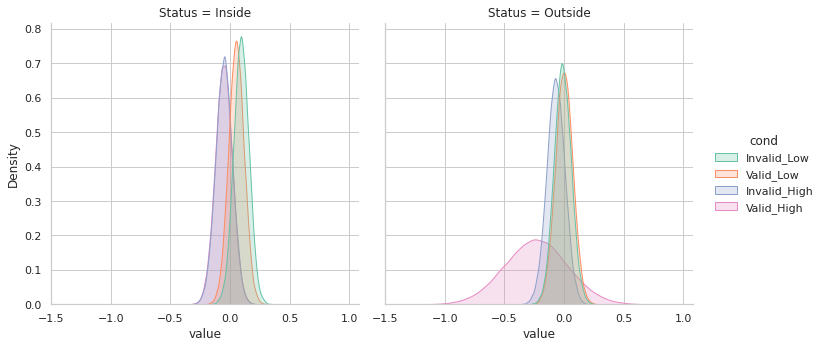

In [56]:
sns.displot(df_melt_p, x="value", col="Status", hue='cond', kind='kde', fill=True)